In [64]:
import os
import numpy as np
import pandas as pd

import logging
import six
import radiomics
from radiomics import featureextractor
import SimpleITK as sitk

import scipy.ndimage as ndimage
import matplotlib.pyplot as plt

import image_perturbation as impt

import glob
import datetime
import itertools
import file_structure
(origdir,basedir,imagedir,normdir,splitdir,out_dir,model_dir) = file_structure.file_dirs('texture')

modal_list = ['FLAIR','T1', 'T1post','T2']

#load the parameters for extractor
params = 'texture_settings.yaml'
extractor = featureextractor.RadiomicsFeaturesExtractor(params)

# it is already pre-processed such that every voxel is 1x1x1mm.
data_spacing = [1,1,1]

# set up a logger
# Get the PyRadiomics logger (default log-level = INFO)
logger = radiomics.logger
logger.setLevel(logging.DEBUG)  # set level to DEBUG to include debug log messages in log file

# Write out all log entries to a file
handler = logging.FileHandler(filename='Log_2D_test.txt', mode='w')
formatter = logging.Formatter('%(levelname)s:%(name)s: %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [3]:
mask = np.load(os.path.join(splitdir,'slices_exp_mask.npy'))
img = {}
inten_dic = {}
for modal in modal_list:
    #load image and mask
    img[modal] = np.load(os.path.join(splitdir,'slices_exp_%s.npy' % (modal)))


# tau_vec = np.arange(-.28,.28+.2,.02)
features = {}
# case = 'C'
case_tau = {'R' : np.arange(-13,13+1,1),'N':np.arange(1,30+1,1),'T':[p for p in itertools.product([0,1/3,2/3], repeat=2)],
           'V': np.arange(-.28,.28+.2,.02),'C': np.arange(1,30+1,1)}
cases = case_tau.keys()

for modal in modal_list:
    features[modal] = {}

    # [n_slices, x_dim, y_dim, views]
    n_slices = img[modal].shape[0]
    
#     slice_ind = 25
#     if 1:
    for slice_ind in range(n_slices):

        features[modal][slice_ind] = {}

        # for view_ind in range(len(views)):
            # pick slice and view
        img_slice = img[modal][slice_ind,:,:,2]
        mask_slice = (mask[slice_ind,:,:,2] > 0) * 1
        for case in cases:
            print('%s %s - %d' % (modal,case,slice_ind), datetime.datetime.now().time())
            features[modal][slice_ind][case] = {}
            tau_vec = case_tau[case]
            
            for adi in range(len(tau_vec)):
    #             print('%s - %d - %f' % (modal,slice_ind,tau))
                features[modal][slice_ind][case][adi] = {}
                tau = tau_vec[adi]
                if case == 'R':
                    adj_mask = impt.rotate_image(mask_slice,tau,mask_slice)
                    adj_slice = impt.rotate_image(img_slice,tau,mask_slice)
                elif case == 'N':
                    np.random.seed(tau)
                    adj_slice = impt.add_noise(img_slice,reps=1)
                    adj_mask = mask_slice.copy()
                elif case == 'T':
                    adj_slice = impt.translate_image(img_slice,shift=tau)
                    adj_mask = impt.translate_image(mask_slice,shift=tau)
                elif case == 'V':
                    adj_slice = img_slice.copy()
                    adj_mask = impt.grow_shrink_image(mask_slice,tau)
                elif case == 'C':
                    np.random.seed(tau)
                    adj_slice = img_slice.copy()
                    adj_mask = impt.adjust_image_contour(img_slice,mask_slice)

                #convert numpy array into sitk

                sitk_img = sitk.GetImageFromArray(adj_slice)
                sitk_img.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
                sitk_img = sitk.JoinSeries(sitk_img)

                sitk_mask = sitk.GetImageFromArray(adj_mask)
                sitk_mask.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
                sitk_mask = sitk.JoinSeries(sitk_mask)
                sitk_mask = sitk.Cast(sitk_mask, sitk.sitkInt32)

                features[modal][slice_ind][case][adi]['z']=extractor.execute(sitk_img, sitk_mask)

FLAIR R - 0 16:42:34.685728
FLAIR N - 0 16:42:51.269726
FLAIR T - 0 16:43:07.556938
FLAIR V - 0 16:43:13.139748
FLAIR C - 0 16:43:37.762073
FLAIR R - 1 16:44:26.943553
FLAIR N - 1 16:44:52.358982
FLAIR T - 1 16:45:17.778421
FLAIR V - 1 16:45:26.258920
FLAIR C - 1 16:46:03.990023
FLAIR R - 2 16:47:01.839500
FLAIR N - 2 16:47:17.024787
FLAIR T - 2 16:47:32.147910
FLAIR V - 2 16:47:37.126117
FLAIR C - 2 16:47:59.978748
FLAIR R - 3 16:48:48.724070
FLAIR N - 3 16:49:08.248870
FLAIR T - 3 16:49:27.692455
FLAIR V - 3 16:49:33.775594
FLAIR C - 3 16:50:03.228735
FLAIR R - 4 16:50:55.776146
FLAIR N - 4 16:51:30.356890
FLAIR T - 4 16:52:06.585005
FLAIR V - 4 16:52:17.774692
FLAIR C - 4 16:53:15.018593
FLAIR R - 5 16:54:25.556173
FLAIR N - 5 16:54:53.618799
FLAIR T - 5 16:55:21.936104
FLAIR V - 5 16:55:31.177679
FLAIR C - 5 16:56:14.969134
FLAIR R - 6 16:57:20.082289
FLAIR N - 6 16:57:44.827092
FLAIR T - 6 16:58:09.690211
FLAIR V - 6 16:58:17.714502
FLAIR C - 6 16:58:56.852339
FLAIR R - 7 16:59:57

FLAIR R - 57 19:12:03.334246
FLAIR N - 57 19:12:24.197597
FLAIR T - 57 19:12:45.298578
FLAIR V - 57 19:12:52.333242
FLAIR C - 57 19:13:24.512616
FLAIR R - 58 19:14:19.609793
FLAIR N - 58 19:14:51.413167
FLAIR T - 58 19:15:24.364589
FLAIR V - 58 19:15:34.620800
FLAIR C - 58 19:16:25.780529
FLAIR R - 59 19:17:33.472119
FLAIR N - 59 19:18:05.624419
FLAIR T - 59 19:18:38.944820
FLAIR V - 59 19:18:49.505839
FLAIR C - 59 19:19:41.376454
FLAIR R - 60 19:20:48.814370
FLAIR N - 60 19:21:18.265506
FLAIR T - 60 19:21:48.895769
FLAIR V - 60 19:21:58.454128
FLAIR C - 60 19:22:46.026340
FLAIR R - 61 19:23:49.926871
FLAIR N - 61 19:24:20.825847
FLAIR T - 61 19:24:53.164643
FLAIR V - 61 19:25:03.219319
FLAIR C - 61 19:25:53.743362
FLAIR R - 62 19:26:59.525886
FLAIR N - 62 19:27:28.733375
FLAIR T - 62 19:27:59.429814
FLAIR V - 62 19:28:08.886905
FLAIR C - 62 19:28:56.484183
FLAIR R - 63 19:30:00.105974
FLAIR N - 63 19:30:27.132679
FLAIR T - 63 19:30:55.546059
FLAIR V - 63 19:31:04.343399
FLAIR C - 63 1

FLAIR N - 113 21:39:47.975511
FLAIR T - 113 21:40:20.431821
FLAIR V - 113 21:40:30.619915
FLAIR C - 113 21:41:21.254567
FLAIR R - 114 21:42:26.925204
FLAIR N - 114 21:42:53.742519
FLAIR T - 114 21:43:21.143386
FLAIR V - 114 21:43:29.964845
FLAIR C - 114 21:44:12.093878
FLAIR R - 115 21:45:13.129847
FLAIR N - 115 21:45:39.459701
FLAIR T - 115 21:46:07.367742
FLAIR V - 115 21:46:16.165082
FLAIR C - 115 21:46:57.656160
FLAIR R - 116 21:47:58.069440
FLAIR N - 116 21:48:20.426755
FLAIR T - 116 21:48:42.572508
FLAIR V - 116 21:48:49.566063
FLAIR C - 116 21:49:23.668538
FLAIR R - 117 21:50:18.985296
FLAIR N - 117 21:50:44.824850
FLAIR T - 117 21:51:11.514659
FLAIR V - 117 21:51:20.119488
FLAIR C - 117 21:52:00.576824
FLAIR R - 118 21:53:00.382491
FLAIR N - 118 21:53:21.232808
FLAIR T - 118 21:53:41.484538
FLAIR V - 118 21:53:48.000825
FLAIR C - 118 21:54:19.687892
FLAIR R - 119 21:55:13.319178
FLAIR N - 119 21:55:33.910809
FLAIR T - 119 21:55:55.765791
FLAIR V - 119 21:56:02.575859
FLAIR C - 

FLAIR R - 168 00:11:30.886415
FLAIR N - 168 00:11:46.012546
FLAIR T - 168 00:12:00.949173
FLAIR V - 168 00:12:05.732865
FLAIR C - 168 00:12:28.198467
FLAIR R - 169 00:13:16.618930
FLAIR N - 169 00:13:32.956272
FLAIR T - 169 00:13:48.670964
FLAIR V - 169 00:13:53.683263
FLAIR C - 169 00:14:17.974708
FLAIR R - 170 00:15:07.464006
FLAIR N - 170 00:15:29.174606
FLAIR T - 170 00:15:50.390893
FLAIR V - 170 00:15:57.116737
FLAIR C - 170 00:16:31.318477
FLAIR R - 171 00:17:26.785634
FLAIR N - 171 00:17:56.155553
FLAIR T - 171 00:18:26.066911
FLAIR V - 171 00:18:35.287373
FLAIR C - 171 00:19:21.040758
FLAIR R - 172 00:20:23.780209
FLAIR N - 172 00:20:53.583278
FLAIR T - 172 00:21:25.107915
FLAIR V - 172 00:21:34.857781
FLAIR C - 172 00:22:24.718063
FLAIR R - 173 00:23:31.874231
FLAIR N - 173 00:24:06.303575
FLAIR T - 173 00:24:41.950297
FLAIR V - 173 00:24:53.142059
FLAIR C - 173 00:25:48.961500
FLAIR R - 174 00:26:59.429895
FLAIR N - 174 00:27:19.719853
FLAIR T - 174 00:27:40.145168
FLAIR V - 

FLAIR C - 222 02:41:55.064625
FLAIR R - 223 02:42:50.478641
FLAIR N - 223 02:43:22.096525
FLAIR T - 223 02:43:54.889526
FLAIR V - 223 02:44:04.891061
FLAIR C - 223 02:44:55.059159
FLAIR R - 224 02:46:00.893822
FLAIR N - 224 02:46:14.937081
FLAIR T - 224 02:46:28.268449
FLAIR V - 224 02:46:32.748333
FLAIR C - 224 02:46:52.771457
FLAIR R - 225 02:47:39.608718
FLAIR N - 225 02:47:58.151914
FLAIR T - 225 02:48:16.216841
FLAIR V - 225 02:48:22.270902
FLAIR C - 225 02:48:50.826662
FLAIR R - 226 02:49:42.894801
FLAIR N - 226 02:50:17.164722
FLAIR T - 226 02:50:52.880477
FLAIR V - 226 02:51:04.174440
FLAIR C - 226 02:52:01.012234
FLAIR R - 227 02:53:10.417369
FLAIR N - 227 02:53:46.324633
FLAIR T - 227 02:54:23.754938
FLAIR V - 227 02:54:35.431917
FLAIR C - 227 02:55:34.169751
FLAIR R - 228 02:56:45.685486
FLAIR N - 228 02:57:15.936744
FLAIR T - 228 02:57:47.024221
FLAIR V - 228 02:57:56.802162
FLAIR C - 228 02:58:45.593608
FLAIR R - 229 02:59:51.377136
FLAIR N - 229 03:00:17.152519
FLAIR T - 

FLAIR V - 277 05:21:19.022750
FLAIR C - 277 05:21:58.993795
FLAIR R - 278 05:23:01.078509
FLAIR N - 278 05:23:26.105909
FLAIR T - 278 05:23:51.925408
FLAIR V - 278 05:23:59.865473
FLAIR C - 278 05:24:39.437460
FLAIR R - 279 05:25:39.665249
FLAIR N - 279 05:26:06.818286
FLAIR T - 279 05:26:34.161830
FLAIR V - 279 05:26:42.846872
FLAIR C - 279 05:27:25.068888
FLAIR R - 280 05:28:24.883580
FLAIR N - 280 05:29:03.394752
FLAIR T - 280 05:29:43.622478
FLAIR V - 280 05:29:56.228923
FLAIR C - 280 05:30:58.511161
FLAIR R - 281 05:32:13.603385
FLAIR N - 281 05:32:50.082165
FLAIR T - 281 05:33:28.307580
FLAIR V - 281 05:33:40.415702
FLAIR C - 281 05:34:40.014822
FLAIR R - 282 05:35:52.613429
FLAIR N - 282 05:36:30.866918
FLAIR T - 282 05:37:10.680545
FLAIR V - 282 05:37:23.190735
FLAIR C - 282 05:38:25.843957
FLAIR R - 283 05:39:39.517417
FLAIR N - 283 05:40:16.923658
FLAIR T - 283 05:40:56.624988
FLAIR V - 283 05:41:09.251487
FLAIR C - 283 05:42:11.230920
FLAIR R - 284 05:43:27.565439
FLAIR N - 

FLAIR T - 332 08:20:01.509657
FLAIR V - 332 08:20:09.297319
FLAIR C - 332 08:20:46.983433
FLAIR R - 333 08:21:45.153123
FLAIR N - 333 08:22:04.570760
FLAIR T - 333 08:22:23.784855
FLAIR V - 333 08:22:29.844971
FLAIR C - 333 08:22:58.617486
FLAIR R - 334 08:23:50.640831
FLAIR N - 334 08:24:15.351544
FLAIR T - 334 08:24:40.083313
FLAIR V - 334 08:24:48.201902
FLAIR C - 334 08:25:25.643471
FLAIR R - 335 08:26:21.849590
FLAIR N - 335 08:26:45.898393
FLAIR T - 335 08:27:10.469581
FLAIR V - 335 08:27:18.152966
FLAIR C - 335 08:27:55.009749
FLAIR R - 336 08:28:50.243286
FLAIR N - 336 08:29:14.472568
FLAIR T - 336 08:29:39.608254
FLAIR V - 336 08:29:47.379872
FLAIR C - 336 08:30:25.100948
FLAIR R - 337 08:31:22.769947
FLAIR N - 337 08:31:47.945740
FLAIR T - 337 08:32:13.395258
FLAIR V - 337 08:32:21.678233
FLAIR C - 337 08:33:00.057054
FLAIR R - 338 08:33:59.057585
FLAIR N - 338 08:34:24.239394
FLAIR T - 338 08:34:50.307554
FLAIR V - 338 08:34:58.419076
FLAIR C - 338 08:35:37.647148
FLAIR R - 

FLAIR N - 387 10:49:55.488747
FLAIR T - 387 10:50:23.019788
FLAIR V - 387 10:50:31.822178
FLAIR C - 387 10:51:15.088236
FLAIR R - 388 10:52:18.417647
FLAIR N - 388 10:52:50.638331
FLAIR T - 388 10:53:23.373383
FLAIR V - 388 10:53:33.768025
FLAIR C - 388 10:54:22.930763
FLAIR R - 389 10:55:28.472041
FLAIR N - 389 10:55:57.727657
FLAIR T - 389 10:56:28.183459
FLAIR V - 389 10:56:37.593423
FLAIR C - 389 10:57:25.531606
FLAIR R - 390 10:58:30.381656
FLAIR N - 390 10:58:58.625589
FLAIR T - 390 10:59:27.065040
FLAIR V - 390 10:59:35.789185
FLAIR C - 390 11:00:19.295610
FLAIR R - 391 11:01:20.962216
FLAIR N - 391 11:01:50.007272
FLAIR T - 391 11:02:19.778256
FLAIR V - 391 11:02:29.500049
FLAIR C - 391 11:03:16.824603
FLAIR R - 392 11:04:21.237494
FLAIR N - 392 11:04:49.208703
FLAIR T - 392 11:05:17.828633
FLAIR V - 392 11:05:27.090205
FLAIR C - 392 11:06:11.609317
FLAIR R - 393 11:07:14.041953
FLAIR N - 393 11:07:45.303892
FLAIR T - 393 11:08:17.266691
FLAIR V - 393 11:08:27.528917
FLAIR C - 

FLAIR R - 442 13:07:00.094696
FLAIR N - 442 13:07:16.626659
FLAIR T - 442 13:07:32.601140
FLAIR V - 442 13:07:37.943346
FLAIR C - 442 13:08:02.379328
FLAIR R - 443 13:08:49.772361
FLAIR N - 443 13:09:06.669294
FLAIR T - 443 13:09:23.791828
FLAIR V - 443 13:09:29.280424
FLAIR C - 443 13:09:54.956592
FLAIR R - 444 13:10:44.197230
FLAIR N - 444 13:11:12.497311
FLAIR T - 444 13:11:41.840159
FLAIR V - 444 13:11:50.960356
FLAIR C - 444 13:12:36.249510
FLAIR R - 445 13:13:38.642041
FLAIR N - 445 13:13:57.909157
FLAIR T - 445 13:14:16.645866
FLAIR V - 445 13:14:22.518446
FLAIR C - 445 13:14:50.213926
FLAIR R - 446 13:15:42.290085
FLAIR N - 446 13:16:11.386278
FLAIR T - 446 13:16:41.285555
FLAIR V - 446 13:16:50.737570
FLAIR C - 446 13:17:36.533771
FLAIR R - 447 13:18:39.649809
FLAIR N - 447 13:19:08.964391
FLAIR T - 447 13:19:39.484162
FLAIR V - 447 13:19:48.863986
FLAIR C - 447 13:20:35.446267
FLAIR R - 448 13:21:37.114474
FLAIR N - 448 13:21:56.307268
FLAIR T - 448 13:22:15.145123
FLAIR V - 

FLAIR C - 496 15:48:40.857903
FLAIR R - 497 15:49:52.237724
FLAIR N - 497 15:50:25.655590
FLAIR T - 497 15:51:00.300722
FLAIR V - 497 15:51:11.264880
FLAIR C - 497 15:52:05.419696
FLAIR R - 498 15:53:13.666759
FLAIR N - 498 15:53:43.104859
FLAIR T - 498 15:54:13.430314
FLAIR V - 498 15:54:23.140075
FLAIR C - 498 15:55:09.705616
FLAIR R - 499 15:56:13.801665
FLAIR N - 499 15:56:43.623785
FLAIR T - 499 15:57:14.052514
FLAIR V - 499 15:57:23.733197
FLAIR C - 499 15:58:11.122925
FLAIR R - 500 15:59:15.412488
FLAIR N - 500 15:59:40.821900
FLAIR T - 500 16:00:06.122023
FLAIR V - 500 16:00:14.400987
FLAIR C - 500 16:00:53.660144
FLAIR R - 501 16:01:52.898306
FLAIR N - 501 16:02:19.871868
FLAIR T - 501 16:02:47.530247
FLAIR V - 501 16:02:56.786806
FLAIR C - 501 16:03:39.322656
FLAIR R - 502 16:04:40.018685
FLAIR N - 502 16:05:04.648027
FLAIR T - 502 16:05:29.899019
FLAIR V - 502 16:05:37.776921
FLAIR C - 502 16:06:16.811480
FLAIR R - 503 16:07:15.633538
FLAIR N - 503 16:07:40.102456
FLAIR T - 

T1 C - 36 18:22:59.584450
T1 R - 37 18:24:08.525899
T1 N - 37 18:24:46.098816
T1 T - 37 18:25:25.756277
T1 V - 37 18:25:38.257520
T1 C - 37 18:26:39.661776
T1 R - 38 18:27:50.914894
T1 N - 38 18:28:07.839798
T1 T - 38 18:28:24.603272
T1 V - 38 18:28:30.033125
T1 C - 38 18:28:55.719294
T1 R - 39 18:29:43.199358
T1 N - 39 18:29:57.184462
T1 T - 39 18:30:10.671276
T1 V - 39 18:30:15.026799
T1 C - 39 18:30:35.854994
T1 R - 40 18:31:19.233324
T1 N - 40 18:31:31.740507
T1 T - 40 18:31:43.761733
T1 V - 40 18:31:47.729226
T1 C - 40 18:32:06.131047
T1 R - 41 18:32:49.402931
T1 N - 41 18:33:08.545718
T1 T - 41 18:33:27.737635
T1 V - 41 18:33:33.930064
T1 C - 41 18:34:03.330063
T1 R - 42 18:34:53.935563
T1 N - 42 18:35:22.971575
T1 T - 42 18:35:52.904990
T1 V - 42 18:36:02.457334
T1 C - 42 18:36:49.050948
T1 R - 43 18:37:50.354895
T1 N - 43 18:38:13.388979
T1 T - 43 18:38:36.913390
T1 V - 43 18:38:44.376190
T1 C - 43 18:39:20.947215
T1 R - 44 18:40:15.788437
T1 N - 44 18:40:38.590911
T1 T - 44 18

T1 R - 100 20:53:44.731685
T1 N - 100 20:54:04.699660
T1 T - 100 20:54:24.810015
T1 V - 100 20:54:31.189940
T1 C - 100 20:55:02.199210
T1 R - 101 20:55:53.811969
T1 N - 101 20:56:13.577406
T1 T - 101 20:56:33.426068
T1 V - 101 20:56:39.655593
T1 C - 101 20:57:10.026168
T1 R - 102 20:58:01.308071
T1 N - 102 20:58:26.901973
T1 T - 102 20:58:53.053353
T1 V - 102 20:59:01.333320
T1 C - 102 20:59:42.147603
T1 R - 103 21:00:40.537908
T1 N - 103 21:01:07.056263
T1 T - 103 21:01:34.370733
T1 V - 103 21:01:43.023744
T1 C - 103 21:02:25.295188
T1 R - 104 21:03:24.203686
T1 N - 104 21:03:47.527687
T1 T - 104 21:04:11.294893
T1 V - 104 21:04:18.896105
T1 C - 104 21:04:55.099380
T1 R - 105 21:05:50.677797
T1 N - 105 21:06:14.402889
T1 T - 105 21:06:38.564111
T1 V - 105 21:06:46.336732
T1 C - 105 21:07:23.319850
T1 R - 106 21:08:19.114404
T1 N - 106 21:08:48.988662
T1 T - 106 21:09:20.057088
T1 V - 106 21:09:29.828011
T1 C - 106 21:10:17.736115
T1 R - 107 21:11:20.320258
T1 N - 107 21:11:51.978436
T

T1 C - 160 23:31:08.615690
T1 R - 161 23:32:05.773755
T1 N - 161 23:32:30.741150
T1 T - 161 23:32:56.400296
T1 V - 161 23:33:04.397512
T1 C - 161 23:33:44.237209
T1 R - 162 23:34:42.128858
T1 N - 162 23:35:10.434955
T1 T - 162 23:35:39.889100
T1 V - 162 23:35:49.043387
T1 C - 162 23:36:34.510013
T1 R - 163 23:37:35.933881
T1 N - 163 23:37:54.383863
T1 T - 163 23:38:12.805704
T1 V - 163 23:38:18.712373
T1 C - 163 23:38:46.120088
T1 R - 164 23:39:36.058617
T1 N - 164 23:40:02.950964
T1 T - 164 23:40:30.541162
T1 V - 164 23:40:39.294386
T1 C - 164 23:41:21.809178
T1 R - 165 23:42:21.243919
T1 N - 165 23:42:49.306369
T1 T - 165 23:43:18.410584
T1 V - 165 23:43:27.715269
T1 C - 165 23:44:12.404834
T1 R - 166 23:45:12.879946
T1 N - 166 23:45:35.038708
T1 T - 166 23:45:57.620619
T1 V - 166 23:46:04.885894
T1 C - 166 23:46:39.122726
T1 R - 167 23:47:32.479581
T1 N - 167 23:47:51.655455
T1 T - 167 23:48:10.813281
T1 V - 167 23:48:16.984656
T1 C - 167 23:48:46.515000
T1 R - 168 23:49:37.026917
T

T1 V - 221 02:07:00.695245
T1 C - 221 02:07:42.802958
T1 R - 222 02:08:42.055714
T1 N - 222 02:09:01.912395
T1 T - 222 02:09:21.743006
T1 V - 222 02:09:27.976544
T1 C - 222 02:09:58.701058
T1 R - 223 02:10:50.373496
T1 N - 223 02:11:19.615075
T1 T - 223 02:11:49.950558
T1 V - 223 02:11:59.436723
T1 C - 223 02:12:46.294039
T1 R - 224 02:13:47.897433
T1 N - 224 02:14:00.883887
T1 T - 224 02:14:13.063750
T1 V - 224 02:14:17.191702
T1 C - 224 02:14:35.654686
T1 R - 225 02:15:19.299384
T1 N - 225 02:15:36.670469
T1 T - 225 02:15:53.669570
T1 V - 225 02:15:59.324572
T1 C - 225 02:16:25.633371
T1 R - 226 02:17:14.636594
T1 N - 226 02:17:46.973362
T1 T - 226 02:18:20.552451
T1 V - 226 02:18:31.135528
T1 C - 226 02:19:23.560636
T1 R - 227 02:20:28.831574
T1 N - 227 02:21:02.479843
T1 T - 227 02:21:37.866727
T1 V - 227 02:21:48.967177
T1 C - 227 02:22:43.859887
T1 R - 228 02:23:50.672228
T1 N - 228 02:24:19.063551
T1 T - 228 02:24:48.354284
T1 V - 228 02:24:57.483481
T1 C - 228 02:25:43.155651
T

T1 T - 282 04:52:59.526194
T1 V - 282 04:53:11.268244
T1 C - 282 04:54:09.180889
T1 R - 283 04:55:18.559706
T1 N - 283 04:55:54.120048
T1 T - 283 04:56:31.455100
T1 V - 283 04:56:43.171183
T1 C - 283 04:57:41.436764
T1 R - 284 04:58:50.878260
T1 N - 284 04:59:27.824279
T1 T - 284 05:00:06.358510
T1 V - 284 05:00:18.464630
T1 C - 284 05:01:18.394628
T1 R - 285 05:02:28.792513
T1 N - 285 05:02:59.427791
T1 T - 285 05:03:31.394599
T1 V - 285 05:03:41.487376
T1 C - 285 05:04:30.959630
T1 R - 286 05:05:34.033218
T1 N - 286 05:06:08.615968
T1 T - 286 05:06:44.917277
T1 V - 286 05:06:56.347603
T1 C - 286 05:07:52.576781
T1 R - 287 05:09:01.032168
T1 N - 287 05:09:28.807898
T1 T - 287 05:09:57.359631
T1 V - 287 05:10:06.429694
T1 C - 287 05:10:50.885615
T1 R - 288 05:11:51.577468
T1 N - 288 05:12:28.086329
T1 T - 288 05:13:06.528316
T1 V - 288 05:13:18.669529
T1 C - 288 05:14:18.218514
T1 R - 289 05:15:28.180060
T1 N - 289 05:16:06.339298
T1 T - 289 05:16:46.120841
T1 V - 289 05:16:58.745335
T

T1 N - 343 07:52:14.991033
T1 T - 343 07:52:41.712928
T1 V - 343 07:52:50.214483
T1 C - 343 07:53:31.777752
T1 R - 344 07:54:30.477381
T1 N - 344 07:54:58.504913
T1 T - 344 07:55:27.288458
T1 V - 344 07:55:36.476892
T1 C - 344 07:56:21.160720
T1 R - 345 07:57:21.328567
T1 N - 345 07:57:49.127490
T1 T - 345 07:58:17.920059
T1 V - 345 07:58:27.097464
T1 C - 345 07:59:11.804216
T1 R - 346 08:00:11.571186
T1 N - 346 08:00:36.297787
T1 T - 346 08:01:01.518699
T1 V - 346 08:01:09.640247
T1 C - 346 08:01:48.695863
T1 R - 347 08:02:45.226488
T1 N - 347 08:03:13.619818
T1 T - 347 08:03:43.017812
T1 V - 347 08:03:52.387671
T1 C - 347 08:04:38.201216
T1 R - 348 08:05:39.456261
T1 N - 348 08:06:06.972262
T1 T - 348 08:06:35.404695
T1 V - 348 08:06:44.420615
T1 C - 348 08:07:28.587793
T1 R - 349 08:08:28.649286
T1 N - 349 08:08:54.581085
T1 T - 349 08:09:21.614808
T1 V - 349 08:09:30.253726
T1 C - 349 08:10:12.047641
T1 R - 350 08:11:09.838358
T1 N - 350 08:11:34.407540
T1 T - 350 08:11:59.503121
T

T1 R - 404 10:29:31.808874
T1 N - 404 10:29:47.722091
T1 T - 404 10:30:03.279365
T1 V - 404 10:30:08.300688
T1 C - 404 10:30:31.818080
T1 R - 405 10:31:18.199215
T1 N - 405 10:31:31.989768
T1 T - 405 10:31:45.194802
T1 V - 405 10:31:49.472150
T1 C - 405 10:32:09.960506
T1 R - 406 10:32:54.836214
T1 N - 406 10:33:11.644769
T1 T - 406 10:33:28.213749
T1 V - 406 10:33:33.563921
T1 C - 406 10:33:58.723726
T1 R - 407 10:34:46.661162
T1 N - 407 10:35:05.314767
T1 T - 407 10:35:23.850057
T1 V - 407 10:35:29.850962
T1 C - 407 10:35:58.072990
T1 R - 408 10:36:48.282899
T1 N - 408 10:37:02.066554
T1 T - 408 10:37:15.146337
T1 V - 408 10:37:19.357536
T1 C - 408 10:37:39.395823
T1 R - 409 10:38:23.845392
T1 N - 409 10:38:37.480653
T1 T - 409 10:38:50.432091
T1 V - 409 10:38:54.626218
T1 C - 409 10:39:14.374612
T1 R - 410 10:39:57.422461
T1 N - 410 10:40:15.341000
T1 T - 410 10:40:33.019903
T1 V - 410 10:40:38.732093
T1 C - 410 10:41:05.424874
T1 R - 411 10:41:53.368725
T1 N - 411 10:42:06.841437
T

T1 C - 464 12:45:23.542244
T1 R - 465 12:46:21.769118
T1 N - 465 12:46:48.352646
T1 T - 465 12:47:15.436500
T1 V - 465 12:47:24.187741
T1 C - 465 12:48:06.168117
T1 R - 466 12:49:05.201439
T1 N - 466 12:49:31.360842
T1 T - 466 12:49:58.128857
T1 V - 466 12:50:06.708622
T1 C - 466 12:50:48.639867
T1 R - 467 12:51:47.615906
T1 N - 467 12:52:13.140624
T1 T - 467 12:52:39.390266
T1 V - 467 12:52:47.710339
T1 C - 467 12:53:29.336777
T1 R - 468 12:54:27.449836
T1 N - 468 12:54:51.996938
T1 T - 468 12:55:17.176741
T1 V - 468 12:55:25.327367
T1 C - 468 12:56:04.441137
T1 R - 469 12:57:01.312529
T1 N - 469 12:57:28.240972
T1 T - 469 12:57:55.837186
T1 V - 469 12:58:04.568349
T1 C - 469 12:58:47.935427
T1 R - 470 12:59:47.826621
T1 N - 470 13:00:15.579250
T1 T - 470 13:00:44.243298
T1 V - 470 13:00:53.382545
T1 C - 470 13:01:38.306730
T1 R - 471 13:02:38.875718
T1 N - 471 13:03:06.479953
T1 T - 471 13:03:34.908397
T1 V - 471 13:03:43.895239
T1 C - 471 13:04:27.969148
T1 R - 472 13:05:28.206221
T

T1post N - 5 15:33:42.791203
T1post T - 5 15:34:09.657482
T1post V - 5 15:34:18.128957
T1post C - 5 15:34:59.344302
T1post R - 6 15:35:58.590162
T1post N - 6 15:36:21.622267
T1post T - 6 15:36:45.076491
T1post V - 6 15:36:52.524251
T1post C - 6 15:37:28.929838
T1post R - 7 15:38:24.705806
T1post N - 7 15:38:50.681721
T1post T - 7 15:39:17.243190
T1post V - 7 15:39:25.795881
T1post C - 7 15:40:06.851868
T1post R - 8 15:41:05.368289
T1post N - 8 15:41:25.106656
T1post T - 8 15:41:44.724705
T1post V - 8 15:41:51.002360
T1post C - 8 15:42:21.832153
T1post R - 9 15:43:13.192333
T1post N - 9 15:43:29.157689
T1post T - 9 15:43:44.740030
T1post V - 9 15:43:49.687155
T1post C - 9 15:44:14.410749
T1post R - 10 15:45:01.612410
T1post N - 10 15:45:28.465653
T1post T - 10 15:45:56.278440
T1post V - 10 15:46:05.019631
T1post C - 10 15:46:48.061824
T1post R - 11 15:47:47.824071
T1post N - 11 15:48:12.445394
T1post T - 11 15:48:37.618177
T1post V - 11 15:48:45.502095
T1post C - 11 15:49:24.523621
T1po

T1post R - 60 17:50:16.913503
T1post N - 60 17:50:44.889724
T1post T - 60 17:51:13.841535
T1post V - 60 17:51:22.991812
T1post C - 60 17:52:08.071409
T1post R - 61 17:53:08.043547
T1post N - 61 17:53:37.669124
T1post T - 61 17:54:08.280335
T1post V - 61 17:54:17.810621
T1post C - 61 17:55:05.424990
T1post R - 62 17:56:07.225723
T1post N - 62 17:56:34.910344
T1post T - 62 17:57:03.626709
T1post V - 62 17:57:12.614610
T1post C - 62 17:57:57.325511
T1post R - 63 17:58:58.942841
T1post N - 63 17:59:24.934959
T1post T - 63 17:59:51.629951
T1post V - 63 17:59:59.927001
T1post C - 63 18:00:41.415073
T1post R - 64 18:01:39.715757
T1post N - 64 18:02:10.970677
T1post T - 64 18:02:43.485942
T1post V - 64 18:02:53.678985
T1post C - 64 18:03:44.097749
T1post R - 65 18:04:49.084724
T1post N - 65 18:05:26.269410
T1post T - 65 18:06:05.262829
T1post V - 65 18:06:17.557447
T1post C - 65 18:07:18.159226
T1post R - 66 18:08:29.672435
T1post N - 66 18:08:52.373662
T1post T - 66 18:09:15.296478
T1post V -

T1post N - 114 20:03:13.237727
T1post T - 114 20:03:39.171531
T1post V - 114 20:03:47.514666
T1post C - 114 20:04:27.668196
T1post R - 115 20:05:25.518398
T1post N - 115 20:05:50.418459
T1post T - 115 20:06:15.944179
T1post V - 115 20:06:24.129896
T1post C - 115 20:07:03.530429
T1post R - 116 20:08:01.080638
T1post N - 116 20:08:21.906893
T1post T - 116 20:08:42.794307
T1post V - 116 20:08:49.447962
T1post C - 116 20:09:21.304477
T1post R - 117 20:10:13.748419
T1post N - 117 20:10:38.495074
T1post T - 117 20:11:03.831292
T1post V - 117 20:11:11.798429
T1post C - 117 20:11:50.697630
T1post R - 118 20:12:47.798669
T1post N - 118 20:13:07.119930
T1post T - 118 20:13:26.336914
T1post V - 118 20:13:32.525332
T1post C - 118 20:14:01.916307
T1post R - 119 20:14:53.029167
T1post N - 119 20:15:12.522885
T1post T - 119 20:15:32.153967
T1post V - 119 20:15:38.401544
T1post C - 119 20:16:08.291843
T1post R - 120 20:16:59.434094
T1post N - 120 20:17:26.002582
T1post T - 120 20:17:53.125541
T1post V

T1post N - 167 22:20:42.499009
T1post T - 167 22:21:01.720003
T1post V - 167 22:21:07.937499
T1post C - 167 22:21:37.696451
T1post R - 168 22:22:28.509698
T1post N - 168 22:22:42.491792
T1post T - 168 22:22:55.851235
T1post V - 168 22:23:00.225841
T1post C - 168 22:23:21.093204
T1post R - 169 22:24:06.302773
T1post N - 169 22:24:21.255443
T1post T - 169 22:24:35.818077
T1post V - 169 22:24:40.586727
T1post C - 169 22:25:03.255872
T1post R - 170 22:25:49.806539
T1post N - 170 22:26:09.864753
T1post T - 170 22:26:30.058327
T1post V - 170 22:26:36.566594
T1post C - 170 22:27:07.701196
T1post R - 171 22:27:59.326848
T1post N - 171 22:28:26.436770
T1post T - 171 22:28:54.556373
T1post V - 171 22:29:03.428912
T1post C - 171 22:29:46.902249
T1post R - 172 22:30:47.204247
T1post N - 172 22:31:15.581710
T1post T - 172 22:31:44.938779
T1post V - 172 22:31:54.120196
T1post C - 172 22:32:39.896929
T1post R - 173 22:33:42.045297
T1post N - 173 22:34:14.267985
T1post T - 173 22:34:48.013758
T1post V

T1post N - 220 00:37:09.894216
T1post T - 220 00:37:34.669948
T1post V - 220 00:37:42.581939
T1post C - 220 00:38:20.803341
T1post R - 221 00:39:17.777501
T1post N - 221 00:39:44.215644
T1post T - 221 00:40:11.474965
T1post V - 221 00:40:20.051719
T1post C - 221 00:41:02.019061
T1post R - 222 00:42:00.696702
T1post N - 222 00:42:20.629585
T1post T - 222 00:42:40.628644
T1post V - 222 00:42:46.979494
T1post C - 222 00:43:18.098053
T1post R - 223 00:44:09.495093
T1post N - 223 00:44:38.642422
T1post T - 223 00:45:09.025030
T1post V - 223 00:45:18.472115
T1post C - 223 00:46:05.450753
T1post R - 224 00:47:07.938808
T1post N - 224 00:47:20.935287
T1post T - 224 00:47:33.074493
T1post V - 224 00:47:37.241548
T1post C - 224 00:47:55.795774
T1post R - 225 00:48:39.127133
T1post N - 225 00:48:56.488192
T1post T - 225 00:49:13.477265
T1post V - 225 00:49:19.127255
T1post C - 225 00:49:45.574420
T1post R - 226 00:50:34.535347
T1post N - 226 00:51:06.696673
T1post T - 226 00:51:40.486318
T1post V

T1post N - 273 03:02:10.220472
T1post T - 273 03:02:35.229823
T1post V - 273 03:02:43.190946
T1post C - 273 03:03:21.310077
T1post R - 274 03:04:18.379509
T1post N - 274 03:04:42.557653
T1post T - 274 03:05:07.380511
T1post V - 274 03:05:15.251392
T1post C - 274 03:05:53.224135
T1post R - 275 03:06:50.309009
T1post N - 275 03:07:15.162101
T1post T - 275 03:07:40.467395
T1post V - 275 03:07:48.433581
T1post C - 275 03:08:27.249802
T1post R - 276 03:09:24.559159
T1post N - 276 03:09:49.542575
T1post T - 276 03:10:15.176742
T1post V - 276 03:10:23.349475
T1post C - 276 03:11:02.537688
T1post R - 277 03:11:59.139706
T1post N - 277 03:12:23.184498
T1post T - 277 03:12:47.764710
T1post V - 277 03:12:55.532317
T1post C - 277 03:13:33.254397
T1post R - 278 03:14:29.897124
T1post N - 278 03:14:53.573942
T1post T - 278 03:15:17.694936
T1post V - 278 03:15:25.341220
T1post C - 278 03:16:02.175946
T1post R - 279 03:16:58.825514
T1post N - 279 03:17:24.247962
T1post T - 279 03:17:50.297071
T1post V

T1post N - 326 05:46:36.699906
T1post T - 326 05:46:51.773899
T1post V - 326 05:46:56.545558
T1post C - 326 05:47:18.998125
T1post R - 327 05:48:05.716466
T1post N - 327 05:48:28.356566
T1post T - 327 05:48:51.434781
T1post V - 327 05:48:58.692013
T1post C - 327 05:49:33.858336
T1post R - 328 05:50:28.573893
T1post N - 328 05:50:50.470986
T1post T - 328 05:51:12.813305
T1post V - 328 05:51:19.852023
T1post C - 328 05:51:53.362136
T1post R - 329 05:52:47.162902
T1post N - 329 05:53:09.899286
T1post T - 329 05:53:33.157137
T1post V - 329 05:53:40.396387
T1post C - 329 05:54:14.938245
T1post R - 330 05:55:09.377587
T1post N - 330 05:55:33.104684
T1post T - 330 05:55:57.435387
T1post V - 330 05:56:05.063673
T1post C - 330 05:56:42.253343
T1post R - 331 05:57:38.648331
T1post N - 331 05:58:01.104909
T1post T - 331 05:58:23.887353
T1post V - 331 05:58:30.999243
T1post C - 331 05:59:05.118742
T1post R - 332 05:59:59.273646
T1post N - 332 06:00:22.051075
T1post T - 332 06:00:45.382974
T1post V

T1post N - 379 07:57:22.838012
T1post T - 379 07:57:44.183644
T1post V - 379 07:57:51.069941
T1post C - 379 07:58:23.994263
T1post R - 380 07:59:16.589472
T1post N - 380 07:59:45.540280
T1post T - 380 08:00:15.563933
T1post V - 380 08:00:25.051103
T1post C - 380 08:01:11.406086
T1post R - 381 08:02:13.851681
T1post N - 381 08:02:44.307482
T1post T - 381 08:03:15.902338
T1post V - 381 08:03:25.877770
T1post C - 381 08:04:14.665206
T1post R - 382 08:05:18.750793
T1post N - 382 08:05:45.656174
T1post T - 382 08:06:13.353680
T1post V - 382 08:06:22.192108
T1post C - 382 08:07:05.059836
T1post R - 383 08:08:04.903268
T1post N - 383 08:08:30.704721
T1post T - 383 08:08:57.212046
T1post V - 383 08:09:05.763734
T1post C - 383 08:09:47.813293
T1post R - 384 08:10:45.517763
T1post N - 384 08:11:17.057438
T1post T - 384 08:11:49.712073
T1post V - 384 08:12:00.234990
T1post C - 384 08:12:51.095927
T1post R - 385 08:13:56.768594
T1post N - 385 08:14:27.750789
T1post T - 385 08:14:59.699551
T1post V

T1post N - 432 10:05:32.918444
T1post T - 432 10:05:55.001028
T1post V - 432 10:06:01.928407
T1post C - 432 10:06:35.887502
T1post R - 433 10:07:29.706119
T1post N - 433 10:07:51.843851
T1post T - 433 10:08:14.203171
T1post V - 433 10:08:21.335093
T1post C - 433 10:08:55.986023
T1post R - 434 10:09:50.302207
T1post N - 434 10:10:11.352054
T1post T - 434 10:10:32.708712
T1post V - 434 10:10:39.498727
T1post C - 434 10:11:12.317797
T1post R - 435 10:12:03.984377
T1post N - 435 10:12:26.561273
T1post T - 435 10:12:49.581346
T1post V - 435 10:12:56.826569
T1post C - 435 10:13:31.960782
T1post R - 436 10:14:25.107822
T1post N - 436 10:14:46.952777
T1post T - 436 10:15:08.945125
T1post V - 436 10:15:15.939681
T1post C - 436 10:15:49.710277
T1post R - 437 10:16:43.644640
T1post N - 437 10:17:06.712841
T1post T - 437 10:17:30.333509
T1post V - 437 10:17:37.776276
T1post C - 437 10:18:14.214927
T1post R - 438 10:19:09.760987
T1post N - 438 10:19:31.639030
T1post T - 438 10:19:53.784782
T1post V

T1post N - 485 12:22:01.063570
T1post T - 485 12:22:34.513315
T1post V - 485 12:22:45.035228
T1post C - 485 12:23:37.143475
T1post R - 486 12:24:42.439706
T1post N - 486 12:25:15.023151
T1post T - 486 12:25:48.989264
T1post V - 486 12:25:59.681654
T1post C - 486 12:26:52.562928
T1post R - 487 12:27:58.213871
T1post N - 487 12:28:34.302639
T1post T - 487 12:29:12.130008
T1post V - 487 12:29:24.098761
T1post C - 487 12:30:22.994983
T1post R - 488 12:31:33.120820
T1post N - 488 12:32:02.047565
T1post T - 488 12:32:31.997022
T1post V - 488 12:32:41.478200
T1post C - 488 12:33:28.479874
T1post R - 489 12:34:29.567700
T1post N - 489 12:35:04.032170
T1post T - 489 12:35:39.913330
T1post V - 489 12:35:51.151145
T1post C - 489 12:36:47.051451
T1post R - 490 12:37:54.996404
T1post N - 490 12:38:26.093906
T1post T - 490 12:38:58.492862
T1post V - 490 12:39:08.676881
T1post C - 490 12:39:59.128732
T1post R - 491 12:41:03.216910
T1post N - 491 12:41:35.393276
T1post T - 491 12:42:09.249119
T1post V

T2 R - 22 14:51:55.449311
T2 N - 22 14:52:24.348981
T2 T - 22 14:52:54.507995
T2 V - 22 14:53:03.946034
T2 C - 22 14:53:50.623875
T2 R - 23 14:54:52.978665
T2 N - 23 14:55:23.050447
T2 T - 23 14:55:54.201090
T2 V - 23 14:56:04.035215
T2 C - 23 14:56:52.544880
T2 R - 24 14:57:55.983733
T2 N - 24 14:58:18.346061
T2 T - 24 14:58:40.940004
T2 V - 24 14:58:48.190239
T2 C - 24 14:59:22.958510
T2 R - 25 15:00:16.419112
T2 N - 25 15:00:40.518049
T2 T - 25 15:01:05.005013
T2 V - 25 15:01:12.900962
T2 C - 25 15:01:50.242028
T2 R - 26 15:02:45.384250
T2 N - 26 15:03:09.044862
T2 T - 26 15:03:33.343328
T2 V - 26 15:03:41.044759
T2 C - 26 15:04:18.518179
T2 R - 27 15:05:14.636563
T2 N - 27 15:05:47.989049
T2 T - 27 15:06:23.108223
T2 V - 27 15:06:34.231733
T2 C - 27 15:07:29.021092
T2 R - 28 15:08:37.145756
T2 N - 28 15:09:05.164090
T2 T - 28 15:09:34.116903
T2 V - 28 15:09:43.247127
T2 C - 28 15:10:27.301004
T2 R - 29 15:11:27.895093
T2 N - 29 15:11:57.409397
T2 T - 29 15:12:28.122882
T2 V - 29 15

T2 N - 85 17:30:34.015852
T2 T - 85 17:30:52.841798
T2 V - 85 17:30:58.834697
T2 C - 85 17:31:28.117387
T2 R - 86 17:32:17.717731
T2 N - 86 17:32:31.335860
T2 T - 86 17:32:44.323339
T2 V - 86 17:32:48.689900
T2 C - 86 17:33:08.264835
T2 R - 87 17:33:53.038795
T2 N - 87 17:34:07.053976
T2 T - 87 17:34:20.532736
T2 V - 87 17:34:24.995576
T2 C - 87 17:34:45.298463
T2 R - 88 17:35:30.504035
T2 N - 88 17:35:45.295278
T2 T - 88 17:35:59.612261
T2 V - 88 17:36:04.291675
T2 C - 88 17:36:26.754270
T2 R - 89 17:37:12.767925
T2 N - 89 17:37:38.883210
T2 T - 89 17:38:05.574023
T2 V - 89 17:38:14.062543
T2 C - 89 17:38:55.929619
T2 R - 90 17:39:54.539168
T2 N - 90 17:40:17.649479
T2 T - 90 17:40:41.144815
T2 V - 90 17:40:48.693843
T2 C - 90 17:41:24.976101
T2 R - 91 17:42:19.992201
T2 N - 91 17:42:51.124831
T2 T - 91 17:43:23.752366
T2 V - 91 17:43:33.980494
T2 C - 91 17:44:24.639775
T2 R - 92 17:45:29.465425
T2 N - 92 17:45:57.678274
T2 T - 92 17:46:26.750404
T2 V - 92 17:46:36.014984
T2 C - 92 17

T2 V - 146 19:59:32.903974
T2 C - 146 20:00:19.510915
T2 R - 147 20:01:21.954635
T2 N - 147 20:01:53.062359
T2 T - 147 20:02:25.226893
T2 V - 147 20:02:35.373877
T2 C - 147 20:03:24.975766
T2 R - 148 20:04:29.063845
T2 N - 148 20:05:01.667321
T2 T - 148 20:05:35.597338
T2 V - 148 20:05:46.349866
T2 C - 148 20:06:38.249593
T2 R - 149 20:07:43.628480
T2 N - 149 20:08:15.296496
T2 T - 149 20:08:48.139631
T2 V - 149 20:08:58.517163
T2 C - 149 20:09:49.475359
T2 R - 150 20:10:53.711835
T2 N - 150 20:11:20.950097
T2 T - 150 20:11:49.217091
T2 V - 150 20:11:58.139764
T2 C - 150 20:12:41.077680
T2 R - 151 20:13:40.897781
T2 N - 151 20:14:07.126368
T2 T - 151 20:14:34.267373
T2 V - 151 20:14:42.716790
T2 C - 151 20:15:24.607930
T2 R - 152 20:16:23.572250
T2 N - 152 20:16:49.973293
T2 T - 152 20:17:17.258682
T2 V - 152 20:17:25.973804
T2 C - 152 20:18:08.121624
T2 R - 153 20:19:06.943152
T2 N - 153 20:19:36.942742
T2 T - 153 20:20:07.904888
T2 V - 153 20:20:17.625678
T2 C - 153 20:21:05.721277
T

T2 T - 207 22:44:35.024402
T2 V - 207 22:44:46.089759
T2 C - 207 22:45:39.743106
T2 R - 208 22:46:46.721280
T2 N - 208 22:47:12.112644
T2 T - 208 22:47:38.015342
T2 V - 208 22:47:46.258213
T2 C - 208 22:48:26.729032
T2 R - 209 22:49:24.415416
T2 N - 209 22:49:44.751368
T2 T - 209 22:50:05.237721
T2 V - 209 22:50:11.780078
T2 C - 209 22:50:43.475166
T2 R - 210 22:51:35.620576
T2 N - 210 22:51:49.626733
T2 T - 210 22:52:03.509566
T2 V - 210 22:52:07.878155
T2 C - 210 22:52:28.284294
T2 R - 211 22:53:13.291491
T2 N - 211 22:53:34.825621
T2 T - 211 22:53:56.544241
T2 V - 211 22:54:03.429508
T2 C - 211 22:54:36.205465
T2 R - 212 22:55:29.267983
T2 N - 212 22:55:44.495382
T2 T - 212 22:55:59.402933
T2 V - 212 22:56:04.137493
T2 C - 212 22:56:26.842732
T2 R - 213 22:57:13.077535
T2 N - 213 22:57:28.212688
T2 T - 213 22:57:42.963824
T2 V - 213 22:57:47.644242
T2 C - 213 22:58:09.751895
T2 R - 214 22:58:55.659431
T2 N - 214 22:59:18.631377
T2 T - 214 22:59:41.958264
T2 V - 214 22:59:49.324807
T

T2 N - 268 01:27:04.019030
T2 T - 268 01:27:27.636690
T2 V - 268 01:27:35.022283
T2 C - 268 01:28:11.402802
T2 R - 269 01:29:07.051061
T2 N - 269 01:29:29.684251
T2 T - 269 01:29:52.636285
T2 V - 269 01:29:59.858491
T2 C - 269 01:30:35.183430
T2 R - 270 01:31:28.526757
T2 N - 270 01:31:52.918654
T2 T - 270 01:32:17.877996
T2 V - 270 01:32:25.783018
T2 C - 270 01:33:04.541087
T2 R - 271 01:34:01.896623
T2 N - 271 01:34:25.903314
T2 T - 271 01:34:50.415347
T2 V - 271 01:34:58.118783
T2 C - 271 01:35:36.001288
T2 R - 272 01:36:32.309673
T2 N - 272 01:36:56.484811
T2 T - 272 01:37:21.299669
T2 V - 272 01:37:29.070262
T2 C - 272 01:38:07.008916
T2 R - 273 01:39:01.904837
T2 N - 273 01:39:25.871422
T2 T - 273 01:39:50.414535
T2 V - 273 01:39:58.179136
T2 C - 273 01:40:35.910237
T2 R - 274 01:41:32.742826
T2 N - 274 01:41:56.250192
T2 T - 274 01:42:20.436360
T2 V - 274 01:42:28.090667
T2 C - 274 01:43:05.277326
T2 R - 275 01:43:59.501095
T2 N - 275 01:44:23.967980
T2 T - 275 01:44:48.945245
T

T2 R - 329 04:29:46.974797
T2 N - 329 04:30:09.619876
T2 T - 329 04:30:32.910667
T2 V - 329 04:30:40.152904
T2 C - 329 04:31:14.804814
T2 R - 330 04:32:08.554838
T2 N - 330 04:32:32.289808
T2 T - 330 04:32:56.687537
T2 V - 330 04:33:04.315776
T2 C - 330 04:33:41.306915
T2 R - 331 04:34:37.138379
T2 N - 331 04:34:59.710262
T2 T - 331 04:35:22.582945
T2 V - 331 04:35:29.768007
T2 C - 331 04:36:04.241467
T2 R - 332 04:36:58.290680
T2 N - 332 04:37:21.138296
T2 T - 332 04:37:44.580490
T2 V - 332 04:37:51.881860
T2 C - 332 04:38:26.968981
T2 R - 333 04:39:21.396048
T2 N - 333 04:39:39.369845
T2 T - 333 04:39:57.381743
T2 V - 333 04:40:03.090926
T2 C - 333 04:40:30.064658
T2 R - 334 04:41:19.694124
T2 N - 334 04:41:42.663204
T2 T - 334 04:42:06.092509
T2 V - 334 04:42:13.495195
T2 C - 334 04:42:48.686752
T2 R - 335 04:43:43.434915
T2 N - 335 04:44:06.004234
T2 T - 335 04:44:29.021806
T2 V - 335 04:44:36.178213
T2 C - 335 04:45:10.824365
T2 R - 336 04:46:05.619058
T2 N - 336 04:46:28.423013
T

T2 C - 389 07:04:42.822056
T2 R - 390 07:05:42.998901
T2 N - 390 07:06:08.602991
T2 T - 390 07:06:34.832743
T2 V - 390 07:06:43.138830
T2 C - 390 07:07:23.776922
T2 R - 391 07:08:21.905042
T2 N - 391 07:08:49.520480
T2 T - 391 07:09:17.825752
T2 V - 391 07:09:26.756501
T2 C - 391 07:10:10.664012
T2 R - 392 07:11:10.967472
T2 N - 392 07:11:37.209114
T2 T - 392 07:12:04.187668
T2 V - 392 07:12:12.765425
T2 C - 392 07:12:54.655562
T2 R - 393 07:13:53.755368
T2 N - 393 07:14:23.038058
T2 T - 393 07:14:53.338445
T2 V - 393 07:15:02.901817
T2 C - 393 07:15:49.862406
T2 R - 394 07:16:52.001467
T2 N - 394 07:17:17.942289
T2 T - 394 07:17:44.466661
T2 V - 394 07:17:52.882011
T2 C - 394 07:18:33.893792
T2 R - 395 07:19:31.681003
T2 N - 395 07:19:59.265186
T2 T - 395 07:20:27.834983
T2 V - 395 07:20:36.903040
T2 C - 395 07:21:21.163465
T2 R - 396 07:22:21.998596
T2 N - 396 07:22:48.509933
T2 T - 396 07:23:15.890576
T2 V - 396 07:23:24.591658
T2 C - 396 07:24:06.939008
T2 R - 397 07:25:06.738674
T

T2 V - 450 09:24:40.792203
T2 C - 450 09:25:22.174995
T2 R - 451 09:26:20.701738
T2 N - 451 09:26:40.340839
T2 T - 451 09:27:00.160423
T2 V - 451 09:27:06.389972
T2 C - 451 09:27:36.472760
T2 R - 452 09:28:27.945671
T2 N - 452 09:28:53.235767
T2 T - 452 09:29:19.181603
T2 V - 452 09:29:27.304153
T2 C - 452 09:30:07.020522
T2 R - 453 09:31:03.313545
T2 N - 453 09:31:27.917850
T2 T - 453 09:31:53.168813
T2 V - 453 09:32:01.116902
T2 C - 453 09:32:39.924861
T2 R - 454 09:33:37.010447
T2 N - 454 09:33:59.134142
T2 T - 454 09:34:21.732096
T2 V - 454 09:34:28.897105
T2 C - 454 09:35:03.482861
T2 R - 455 09:35:55.877585
T2 N - 455 09:36:17.390661
T2 T - 455 09:36:39.198516
T2 V - 455 09:36:46.128903
T2 C - 455 09:37:19.186606
T2 R - 456 09:38:12.575858
T2 N - 456 09:38:34.649421
T2 T - 456 09:38:56.983675
T2 V - 456 09:39:04.070476
T2 C - 456 09:39:38.203031
T2 R - 457 09:40:33.074043
T2 N - 457 09:40:55.326078
T2 T - 457 09:41:18.026303
T2 V - 457 09:41:25.179280
T2 C - 457 09:41:59.745989
T

T2 T - 511 12:14:36.658227
T2 V - 511 12:14:44.469952
T2 C - 511 12:15:23.300971
T2 R - 512 12:16:20.111940
T2 N - 512 12:16:45.514333
T2 T - 512 12:17:11.493256
T2 V - 512 12:17:19.703037
T2 C - 512 12:17:59.719202
T2 R - 513 12:18:57.644374
T2 N - 513 12:19:22.682804
T2 T - 513 12:19:47.822548
T2 V - 513 12:19:55.736544
T2 C - 513 12:20:34.496376
T2 R - 514 12:21:31.574126
T2 N - 514 12:21:56.057080
T2 T - 514 12:22:21.075456
T2 V - 514 12:22:28.890189
T2 C - 514 12:23:07.367272
T2 R - 515 12:24:03.855290
T2 N - 515 12:24:28.220967
T2 T - 515 12:24:53.341581
T2 V - 515 12:25:01.165338
T2 C - 515 12:25:39.685533
T2 R - 516 12:26:36.745733
T2 N - 516 12:27:01.458296
T2 T - 516 12:27:26.893779
T2 V - 516 12:27:34.731571
T2 C - 516 12:28:13.657846
T2 R - 517 12:29:08.807674
T2 N - 517 12:29:32.661961
T2 T - 517 12:29:57.059713
T2 V - 517 12:30:04.721017
T2 C - 517 12:30:42.213485
T2 R - 518 12:31:38.624344
T2 N - 518 12:32:02.483645
T2 T - 518 12:32:26.865330
T2 V - 518 12:32:34.537685
T

In [8]:
# obtain feature names
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), features['T1'][1]['R'][0]['z'] )))

feature_names_all = []

for modal in modal_list:

    feature_names_all.append([elemt + '_'+ modal for elemt in feature_names])

feature_names_all_flattened = [val for sublist in feature_names_all for val in sublist]

# remove "original_"
feature_names_all_flattened = [elmt[9:] for elmt in feature_names_all_flattened]

print('number of features are ', len(feature_names_all_flattened))

number of features are  364


In [134]:
samples = np.zeros( (n_slices, len(feature_names)*len(modal_list) ,5,38))
cases = list(cases)
for ci in range(5):
    case = cases[ci]
    for adi in range(38):
        for slice_ind in range(n_slices):
            if adi >= len(features[modal][slice_ind][case]):
                continue
            a = np.array([])

            for modal in modal_list:

                for feature_name in feature_names:

                        a = np.append(a,  features[modal][slice_ind][case][adi]['z'][feature_name]) 
            samples[slice_ind,:,ci,adi] = a

np.save(os.path.join(splitdir,'slices_texture_perturbation.npy'),samples)

In [17]:
temp = np.load(os.path.join(splitdir,'slices_texture_perturbation.npy'))

In [13]:
import pickle
pickle_out = open(os.path.join(splitdir,'slices_texture_perturbation.pkl'),"wb")
pickle.dump(features, pickle_out)
pickle_out.close()

In [18]:
print(temp.shape)

(520, 364, 5, 30)


In [38]:
print(samples[:,0,0,0:27].ravel())
ids = np.load(os.path.join(splitdir,'label_id.npy'))
groups = np.matlib.repmat(range(samples.shape[0]), 27, 1).T.ravel()
print(groups)

[-0.37100403 -0.36795334 -0.37270268 ... -0.36720097 -0.36385
 -0.3685387 ]
[  0   0   0 ... 519 519 519]


In [137]:
from rpy2.robjects import DataFrame, FloatVector, IntVector
from rpy2.robjects.packages import importr
from math import isclose

ids = np.load(os.path.join(splitdir,'label_id.npy'))
icc_vals = np.zeros((samples.shape[1],samples.shape[2],10))
# fold_num = 0
dataset = 'train'
for fold_num in range(10):
    icc_vals_fold = np.zeros((samples.shape[1],samples.shape[2]))
    fold_dir = os.path.join(splitdir,'fold_' +str(fold_num))
    setIdxs = np.load(os.path.join(fold_dir,dataset + '_idxs.npy')) # e.g. train, test, val

    tr_id = np.empty(len(setIdxs))

    for s_o in range(len(setIdxs)):
        s_i = setIdxs[s_o]
        tr_id[s_o]     = ids[s_i]

    tr_samples = samples[setIdxs,:,:,:]
    for prtI in range(len(cases)):
        case = cases[prtI]
        tau_vec = case_tau[case]
        if case == 'V':
            idxs = np.argwhere((np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)) > 0) & (tau_vec >=-.1) & (tau_vec <=.1))
        else:
            idxs = np.argwhere(np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)) > 0)
        groups = np.matlib.repmat(tr_id, len(idxs),1).T.ravel()
        for ftN in range(samples.shape[1]):
            if (ftN % 10) == 0: 
                print('%d %d %d - ' % (fold_num, prtI,ftN), datetime.datetime.now().time())
            values = tr_samples[:,ftN,prtI,idxs].ravel()
            r_icc = importr("ICC")
            df = DataFrame({"groups": IntVector(groups),
                            "values": FloatVector(values)})
            icc_res = r_icc.ICCbare("groups", "values", data=df)
            icc_vals_fold[ftN,prtI] = icc_res[0] # icc_vals now holds the icc value
    icc_vals[:,:,fold_num] = icc_vals_fold
    minICC = np.nanmin(icc_vals_fold,axis = 1)
    minICC[np.isnan(minICC)] = 0
#     np.save(os.path.join(fold_dir,'texture_feature_minICC.npy'),minICC)
# check whether icc value equals reference value
# print(isclose(icc_val, 0.728, abs_tol=0.001))

0 0 0 -  14:53:03.416177
0 0 10 -  14:53:04.230727
0 0 20 -  14:53:04.814560
0 0 30 -  14:53:05.464262
0 0 40 -  14:53:06.048403
0 0 50 -  14:53:06.691559
0 0 60 -  14:53:07.280917
0 0 70 -  14:53:07.871416
0 0 80 -  14:53:08.501511
0 0 90 -  14:53:09.093680
0 0 100 -  14:53:09.742989
0 0 110 -  14:53:10.328365
0 0 120 -  14:53:10.930962
0 0 130 -  14:53:11.536936
0 0 140 -  14:53:12.107564
0 0 150 -  14:53:12.695308
0 0 160 -  14:53:13.278799
0 0 170 -  14:53:13.843900
0 0 180 -  14:53:14.441386
0 0 190 -  14:53:15.022153
0 0 200 -  14:53:15.605095
0 0 210 -  14:53:16.237409
0 0 220 -  14:53:16.839341
0 0 230 -  14:53:17.428727
0 0 240 -  14:53:18.014309
0 0 250 -  14:53:18.584962
0 0 260 -  14:53:19.166672
0 0 270 -  14:53:19.741597
0 0 280 -  14:53:20.348173
0 0 290 -  14:53:20.933210
0 0 300 -  14:53:21.571537
0 0 310 -  14:53:22.142164
0 0 320 -  14:53:22.726712
0 0 330 -  14:53:23.329756
0 0 340 -  14:53:23.913183
0 0 350 -  14:53:24.496388
0 0 360 -  14:53:25.093914
0 1 0 -  14:

C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: All-NaN slice encountered


1 0 0 -  14:54:31.596068
1 0 10 -  14:54:32.253062
1 0 20 -  14:54:32.887062
1 0 30 -  14:54:33.545578
1 0 40 -  14:54:34.167007
1 0 50 -  14:54:34.803223
1 0 60 -  14:54:35.438694
1 0 70 -  14:54:36.085076
1 0 80 -  14:54:36.720729
1 0 90 -  14:54:37.349997
1 0 100 -  14:54:37.998698
1 0 110 -  14:54:38.614537
1 0 120 -  14:54:39.265533
1 0 130 -  14:54:39.881949
1 0 140 -  14:54:40.522832
1 0 150 -  14:54:41.178646
1 0 160 -  14:54:41.793933
1 0 170 -  14:54:42.446377
1 0 180 -  14:54:43.131077
1 0 190 -  14:54:43.757723
1 0 200 -  14:54:44.387993
1 0 210 -  14:54:45.014079
1 0 220 -  14:54:45.645395
1 0 230 -  14:54:46.283052
1 0 240 -  14:54:46.973716
1 0 250 -  14:54:47.593850
1 0 260 -  14:54:48.235635
1 0 270 -  14:54:48.850358
1 0 280 -  14:54:49.513309
1 0 290 -  14:54:50.156571
1 0 300 -  14:54:50.796479
1 0 310 -  14:54:51.472723
1 0 320 -  14:54:52.086146
1 0 330 -  14:54:52.749323
1 0 340 -  14:54:53.403535
1 0 350 -  14:54:54.047451
1 0 360 -  14:54:54.688252
1 1 0 -  14:

2 3 120 -  14:57:18.007549
2 3 130 -  14:57:18.308434
2 3 140 -  14:57:18.627842
2 3 150 -  14:57:18.929484
2 3 160 -  14:57:19.268794
2 3 170 -  14:57:19.582199
2 3 180 -  14:57:19.898744
2 3 190 -  14:57:20.214383
2 3 200 -  14:57:20.532615
2 3 210 -  14:57:20.845440
2 3 220 -  14:57:21.140129
2 3 230 -  14:57:21.506816
2 3 240 -  14:57:21.810125
2 3 250 -  14:57:22.121144
2 3 260 -  14:57:22.445830
2 3 270 -  14:57:22.759520
2 3 280 -  14:57:23.069936
2 3 290 -  14:57:23.372706
2 3 300 -  14:57:23.671974
2 3 310 -  14:57:23.989673
2 3 320 -  14:57:24.304672
2 3 330 -  14:57:24.620498
2 3 340 -  14:57:24.938164
2 3 350 -  14:57:25.241289
2 3 360 -  14:57:25.547691
2 4 0 -  14:57:25.695036
2 4 10 -  14:57:26.554201
2 4 20 -  14:57:27.451453
2 4 30 -  14:57:28.269275
2 4 40 -  14:57:29.123724
2 4 50 -  14:57:29.987891
2 4 60 -  14:57:30.803770
2 4 70 -  14:57:31.639924
2 4 80 -  14:57:32.488427
2 4 90 -  14:57:33.324450
2 4 100 -  14:57:34.140543
2 4 110 -  14:57:34.951801
2 4 120 -  1

4 1 230 -  15:00:39.095120
4 1 240 -  15:00:39.840452
4 1 250 -  15:00:40.597786
4 1 260 -  15:00:41.377082
4 1 270 -  15:00:42.148921
4 1 280 -  15:00:42.898418
4 1 290 -  15:00:43.675927
4 1 300 -  15:00:44.450506
4 1 310 -  15:00:45.220352
4 1 320 -  15:00:45.984151
4 1 330 -  15:00:46.749731
4 1 340 -  15:00:47.557876
4 1 350 -  15:00:48.305429
4 1 360 -  15:00:49.049275
4 2 0 -  15:00:49.369546
4 2 10 -  15:00:49.631126
4 2 20 -  15:00:49.892520
4 2 30 -  15:00:50.179437
4 2 40 -  15:00:50.446319
4 2 50 -  15:00:50.713001
4 2 60 -  15:00:50.981713
4 2 70 -  15:00:51.246985
4 2 80 -  15:00:51.499524
4 2 90 -  15:00:51.759379
4 2 100 -  15:00:52.011075
4 2 110 -  15:00:52.280336
4 2 120 -  15:00:52.540521
4 2 130 -  15:00:52.809953
4 2 140 -  15:00:53.091699
4 2 150 -  15:00:53.366429
4 2 160 -  15:00:53.634167
4 2 170 -  15:00:53.899443
4 2 180 -  15:00:54.154917
4 2 190 -  15:00:54.403604
4 2 200 -  15:00:54.679185
4 2 210 -  15:00:54.937082
4 2 220 -  15:00:55.209638
4 2 230 -  1

5 4 340 -  15:03:11.438528
5 4 350 -  15:03:12.128452
5 4 360 -  15:03:12.797268
6 0 0 -  15:03:13.169130
6 0 10 -  15:03:13.819044
6 0 20 -  15:03:14.479963
6 0 30 -  15:03:15.137682
6 0 40 -  15:03:15.805742
6 0 50 -  15:03:16.461386
6 0 60 -  15:03:17.148229
6 0 70 -  15:03:17.806469
6 0 80 -  15:03:18.444613
6 0 90 -  15:03:19.138329
6 0 100 -  15:03:19.781598
6 0 110 -  15:03:20.439400
6 0 120 -  15:03:21.081980
6 0 130 -  15:03:21.728853
6 0 140 -  15:03:22.382561
6 0 150 -  15:03:23.051987
6 0 160 -  15:03:23.767082
6 0 170 -  15:03:24.416635
6 0 180 -  15:03:25.073353
6 0 190 -  15:03:25.733257
6 0 200 -  15:03:26.373042
6 0 210 -  15:03:27.053607
6 0 220 -  15:03:27.732299
6 0 230 -  15:03:28.421606
6 0 240 -  15:03:29.140135
6 0 250 -  15:03:29.792815
6 0 260 -  15:03:30.446609
6 0 270 -  15:03:31.129518
6 0 280 -  15:03:31.779125
6 0 290 -  15:03:32.446059
6 0 300 -  15:03:33.239345
6 0 310 -  15:03:33.895912
6 0 320 -  15:03:34.558278
6 0 330 -  15:03:35.235000
6 0 340 -  1

7 3 90 -  15:05:59.556807
7 3 100 -  15:05:59.835429
7 3 110 -  15:06:00.125036
7 3 120 -  15:06:00.385505
7 3 130 -  15:06:00.651185
7 3 140 -  15:06:00.932086
7 3 150 -  15:06:01.215445
7 3 160 -  15:06:01.480318
7 3 170 -  15:06:01.746564
7 3 180 -  15:06:02.022638
7 3 190 -  15:06:02.302533
7 3 200 -  15:06:02.577327
7 3 210 -  15:06:02.839144
7 3 220 -  15:06:03.134851
7 3 230 -  15:06:03.445891
7 3 240 -  15:06:03.718590
7 3 250 -  15:06:03.983424
7 3 260 -  15:06:04.247517
7 3 270 -  15:06:04.526886
7 3 280 -  15:06:04.790688
7 3 290 -  15:06:05.061646
7 3 300 -  15:06:05.331628
7 3 310 -  15:06:05.615678
7 3 320 -  15:06:05.886321
7 3 330 -  15:06:06.167030
7 3 340 -  15:06:06.432849
7 3 350 -  15:06:06.703702
7 3 360 -  15:06:06.964480
7 4 0 -  15:06:07.098075
7 4 10 -  15:06:07.840330
7 4 20 -  15:06:08.590675
7 4 30 -  15:06:09.336354
7 4 40 -  15:06:10.129935
7 4 50 -  15:06:10.862411
7 4 60 -  15:06:11.641815
7 4 70 -  15:06:12.389440
7 4 80 -  15:06:13.142721
7 4 90 -  15

9 1 200 -  15:09:19.200921
9 1 210 -  15:09:20.175855
9 1 220 -  15:09:21.125689
9 1 230 -  15:09:22.076831
9 1 240 -  15:09:23.023366
9 1 250 -  15:09:23.996434
9 1 260 -  15:09:24.969229
9 1 270 -  15:09:25.943384
9 1 280 -  15:09:26.865349
9 1 290 -  15:09:27.862894
9 1 300 -  15:09:28.834334
9 1 310 -  15:09:29.804809
9 1 320 -  15:09:30.802776
9 1 330 -  15:09:31.727856
9 1 340 -  15:09:32.726603
9 1 350 -  15:09:33.673855
9 1 360 -  15:09:34.656224
9 2 0 -  15:09:35.045681
9 2 10 -  15:09:35.356267
9 2 20 -  15:09:35.668540
9 2 30 -  15:09:35.994235
9 2 40 -  15:09:36.349248
9 2 50 -  15:09:36.651066
9 2 60 -  15:09:36.962922
9 2 70 -  15:09:37.277101
9 2 80 -  15:09:37.576986
9 2 90 -  15:09:37.894707
9 2 100 -  15:09:38.213601
9 2 110 -  15:09:38.514273
9 2 120 -  15:09:38.828782
9 2 130 -  15:09:39.151726
9 2 140 -  15:09:39.462245
9 2 150 -  15:09:39.782915
9 2 160 -  15:09:40.098880
9 2 170 -  15:09:40.408251
9 2 180 -  15:09:40.715533
9 2 190 -  15:09:41.071586
9 2 200 -  1

In [136]:
tr_samples = samples[setIdxs,:,:,:]
case = 'V'

tau_vec = case_tau[case]
print(tau_vec)
tau_idxs = np.argwhere((np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)) > 0) & (tau_vec >=-.1) & (tau_vec <=.1))
print(tau_idxs)

[-2.80000000e-01 -2.60000000e-01 -2.40000000e-01 -2.20000000e-01
 -2.00000000e-01 -1.80000000e-01 -1.60000000e-01 -1.40000000e-01
 -1.20000000e-01 -1.00000000e-01 -8.00000000e-02 -6.00000000e-02
 -4.00000000e-02 -2.00000000e-02  2.22044605e-16  2.00000000e-02
  4.00000000e-02  6.00000000e-02  8.00000000e-02  1.00000000e-01
  1.20000000e-01  1.40000000e-01  1.60000000e-01  1.80000000e-01
  2.00000000e-01  2.20000000e-01  2.40000000e-01  2.60000000e-01
  2.80000000e-01  3.00000000e-01  3.20000000e-01  3.40000000e-01
  3.60000000e-01  3.80000000e-01  4.00000000e-01  4.20000000e-01
  4.40000000e-01  4.60000000e-01]
[[ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]]


[[0.91337951 0.91359802 0.9113113  0.87876322 0.9123691 ]
 [0.91499376 0.9152561  0.9131939  0.91350821 0.91574435]
 [0.94255987 0.94261878 0.941377   0.94112098 0.94253405]
 ...
 [0.76765619 0.76795373 0.76318424 0.65751822 0.76359021]
 [0.79809895 0.80077376 0.79291786 0.75007778 0.72949306]
 [0.77064035 0.77091722 0.76617124 0.66270506 0.76498108]]


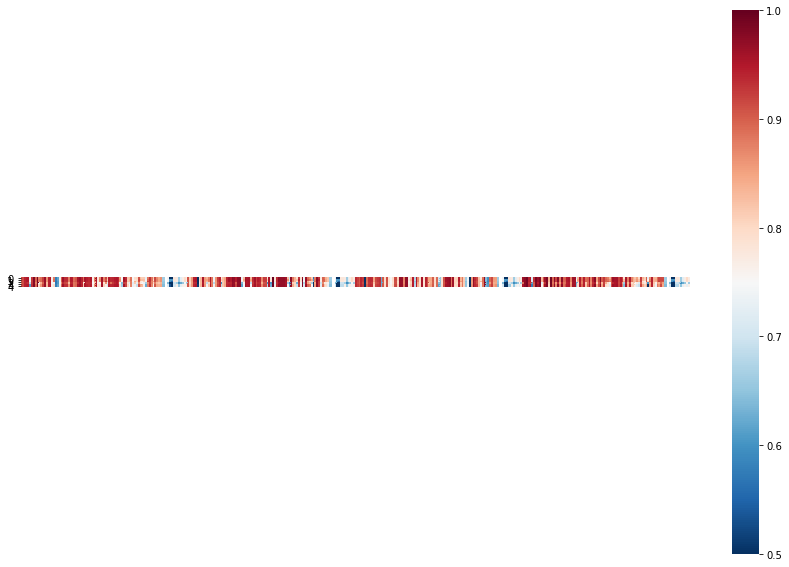

(364,)
253


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: All-NaN slice encountered
  if sys.path[0] == '':
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


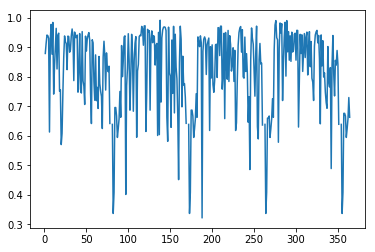

In [138]:
# idxs = np.argwhere(np.count_nonzero(samples[:,:,0,:],axis=(0,1)) > 0)
# print(len(idxs))
# print(idxs)
# print(samples[:,0,0,idxs].shape)
print(icc_vals_fold)
import seaborn as sns
f, ax = plt.subplots(figsize=(15, 10))
# Draw the heatmap using seaborn
sns.heatmap(icc_vals_fold.T, square=True,cmap = 'RdBu_r', xticklabels = False, vmin = .5, vmax = 1)
plt.show()

minICC = np.nanmin(icc_vals_fold,axis = 1)

print(minICC.shape)
print(np.count_nonzero(minICC>.75))
# Draw the heatmap using seaborn
plt.plot( range(1, icc_vals_fold.shape[0] +1),  minICC) 
plt.show()

minICC[np.isnan(minICC)] = 0
np.save(os.path.join(fold_dir,'texture_feature_minICC.npy'),minICC)

In [152]:
from rpy2.robjects import DataFrame, FloatVector, IntVector
from rpy2.robjects.packages import importr
from math import isclose

ids = np.load(os.path.join(splitdir,'label_id.npy'))
icc_vals2 = np.zeros((samples.shape[1],samples.shape[2],10))
# fold_num = 0
dataset = 'train'
for fold_num in range(10):
    icc_vals_fold = np.zeros((samples.shape[1],samples.shape[2]))
    fold_dir = os.path.join(splitdir,'fold_' +str(fold_num))
    setIdxs = np.load(os.path.join(fold_dir,dataset + '_idxs.npy')) # e.g. train, test, val

    tr_id = np.empty(len(setIdxs))

    for s_o in range(len(setIdxs)):
        s_i = setIdxs[s_o]
        tr_id[s_o]     = ids[s_i]

    tr_samples = samples[setIdxs,:,:,:]
    for prtI in range(len(cases)):
        case = cases[prtI]
        tau_vec = case_tau[case]
        if 0: #case == 'V':
            idxs = np.argwhere((np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)) > 0) & (tau_vec >=-.1) & (tau_vec <=.1))
        else:
            idxs = np.argwhere(np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)) > 0)
        groups = np.matlib.repmat(list(range(len(tr_id))), len(idxs),1).T.ravel()
        for ftN in range(samples.shape[1]):
            if (ftN % 10) == 0: 
                print('%d %d %d - ' % (fold_num, prtI,ftN), datetime.datetime.now().time())
            values = tr_samples[:,ftN,prtI,idxs].ravel()
            r_icc = importr("ICC")
            df = DataFrame({"groups": IntVector(groups),
                            "values": FloatVector(values)})
            icc_res = r_icc.ICCbare("groups", "values", data=df)
            icc_vals_fold[ftN,prtI] = icc_res[0] # icc_vals now holds the icc value
    icc_vals2[:,:,fold_num] = icc_vals_fold
    minICC2 = np.nanmin(icc_vals_fold,axis = 1)
    minICC2[np.isnan(minICC2)] = 0
    
    np.save(os.path.join(fold_dir,'tex_feature_icc2.npy'),icc_vals_fold)
    np.save(os.path.join(fold_dir,'tex_feature_min_icc2.npy'),minICC2)
# check whether icc value equals reference value
# print(isclose(icc_val, 0.728, abs_tol=0.001))

0 0 0 -  11:18:00.940790
0 0 10 -  11:18:01.741487
0 0 20 -  11:18:01.987138
0 0 30 -  11:18:02.255338
0 0 40 -  11:18:02.503658
0 0 50 -  11:18:50.888056
0 0 60 -  11:18:51.410442
0 0 70 -  11:18:51.918791
0 0 80 -  11:18:52.378009
0 0 90 -  11:18:52.826198
0 0 100 -  11:18:53.274388
0 0 110 -  11:18:53.831912
0 0 120 -  11:18:54.317480
0 0 130 -  11:18:54.790634
0 0 140 -  11:18:55.266118
0 0 150 -  11:18:56.638759
0 0 160 -  11:18:57.537143
0 0 170 -  11:18:58.046494
0 0 180 -  11:18:58.494683
0 0 190 -  11:18:58.974957
0 0 200 -  11:18:59.495339
0 0 210 -  11:18:59.932498
0 0 220 -  11:19:00.435833
0 0 230 -  11:19:00.906081
0 0 240 -  11:19:01.437071
0 0 250 -  11:19:01.906792
0 0 260 -  11:19:02.399217
0 0 270 -  11:19:02.775343
0 0 280 -  11:19:03.191209
0 0 290 -  11:19:03.729637
0 0 300 -  11:19:04.323212
0 0 310 -  11:19:04.796468
0 0 320 -  11:19:05.270726
0 0 330 -  11:19:05.728942
0 0 340 -  11:19:06.215232
0 0 350 -  11:19:06.664424
0 0 360 -  11:19:07.144698
0 1 0 -  11:

C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: All-NaN slice encountered


1 0 0 -  11:20:01.309593
1 0 10 -  11:20:01.519149
1 0 20 -  11:20:01.764801
1 0 30 -  11:20:01.999423
1 0 40 -  11:20:02.267133
1 0 50 -  11:20:02.528828
1 0 60 -  11:20:02.760443
1 0 70 -  11:20:03.030158
1 0 80 -  11:20:03.299874
1 0 90 -  11:20:03.556554
1 0 100 -  11:20:03.786164
1 0 110 -  11:20:04.017779
1 0 120 -  11:20:04.233350
1 0 130 -  11:20:04.470980
1 0 140 -  11:20:04.724654
1 0 150 -  11:20:04.938444
1 0 160 -  11:20:05.366346
1 0 170 -  11:20:05.658961
1 0 180 -  11:20:05.977389
1 0 190 -  11:20:06.301063
1 0 200 -  11:20:06.561757
1 0 210 -  11:20:06.864558
1 0 220 -  11:20:07.142296
1 0 230 -  11:20:07.388949
1 0 240 -  11:20:07.685737
1 0 250 -  11:20:07.942418
1 0 260 -  11:20:08.243215
1 0 270 -  11:20:08.527971
1 0 280 -  11:20:08.826765
1 0 290 -  11:20:09.114527
1 0 300 -  11:20:09.362184
1 0 310 -  11:20:09.661980
1 0 320 -  11:20:09.928687
1 0 330 -  11:20:10.236504
1 0 340 -  11:20:10.535297
1 0 350 -  11:20:10.821055
1 0 360 -  11:20:11.135890
1 1 0 -  11:

2 3 120 -  11:21:23.841055
2 3 130 -  11:21:24.127089
2 3 140 -  11:21:24.401209
2 3 150 -  11:21:24.721442
2 3 160 -  11:21:24.972005
2 3 170 -  11:21:25.262626
2 3 180 -  11:21:25.594386
2 3 190 -  11:21:25.995644
2 3 200 -  11:21:26.426715
2 3 210 -  11:21:26.904453
2 3 220 -  11:21:27.329899
2 3 230 -  11:21:27.705546
2 3 240 -  11:21:28.168212
2 3 250 -  11:21:28.578995
2 3 260 -  11:21:28.998655
2 3 270 -  11:21:29.436357
2 3 280 -  11:21:29.886400
2 3 290 -  11:21:30.315616
2 3 300 -  11:21:30.733684
2 3 310 -  11:21:31.195937
2 3 320 -  11:21:31.600534
2 3 330 -  11:21:32.049872
2 3 340 -  11:21:32.459661
2 3 350 -  11:21:32.926974
2 3 360 -  11:21:33.332049
2 4 0 -  11:21:33.539872
2 4 10 -  11:21:33.844042
2 4 20 -  11:21:34.249064
2 4 30 -  11:21:34.547696
2 4 40 -  11:21:34.852451
2 4 50 -  11:21:35.206390
2 4 60 -  11:21:35.582387
2 4 70 -  11:21:35.988465
2 4 80 -  11:21:36.354436
2 4 90 -  11:21:36.787585
2 4 100 -  11:21:37.175614
2 4 110 -  11:21:37.500476
2 4 120 -  1

4 1 230 -  11:23:11.133968
4 1 240 -  11:23:11.453816
4 1 250 -  11:23:11.813771
4 1 260 -  11:23:12.131615
4 1 270 -  11:23:12.488562
4 1 280 -  11:23:12.847514
4 1 290 -  11:23:13.241559
4 1 300 -  11:23:13.556395
4 1 310 -  11:23:13.893289
4 1 320 -  11:23:14.231185
4 1 330 -  11:23:14.577102
4 1 340 -  11:23:14.880909
4 1 350 -  11:23:15.233646
4 1 360 -  11:23:15.578118
4 2 0 -  11:23:15.725275
4 2 10 -  11:23:15.925799
4 2 20 -  11:23:16.216425
4 2 30 -  11:23:16.451986
4 2 40 -  11:23:16.731959
4 2 50 -  11:23:16.923291
4 2 60 -  11:23:17.220187
4 2 70 -  11:23:17.432752
4 2 80 -  11:23:17.705475
4 2 90 -  11:23:17.924055
4 2 100 -  11:23:18.184747
4 2 110 -  11:23:18.495571
4 2 120 -  11:23:18.868560
4 2 130 -  11:23:19.337805
4 2 140 -  11:23:19.728842
4 2 150 -  11:23:20.118878
4 2 160 -  11:23:20.506907
4 2 170 -  11:23:20.891928
4 2 180 -  11:23:21.287979
4 2 190 -  11:23:21.724136
4 2 200 -  11:23:22.150160
4 2 210 -  11:23:22.545374
4 2 220 -  11:23:23.038318
4 2 230 -  1

5 4 340 -  11:25:16.354038
5 4 350 -  11:25:16.791198
5 4 360 -  11:25:17.238385
6 0 0 -  11:25:17.776814
6 0 10 -  11:25:18.239040
6 0 20 -  11:25:18.736359
6 0 30 -  11:25:19.222649
6 0 40 -  11:25:19.659809
6 0 50 -  11:25:20.059615
6 0 60 -  11:25:20.551115
6 0 70 -  11:25:20.983922
6 0 80 -  11:25:21.493086
6 0 90 -  11:25:22.051007
6 0 100 -  11:25:22.468522
6 0 110 -  11:25:23.019595
6 0 120 -  11:25:23.493031
6 0 130 -  11:25:23.963822
6 0 140 -  11:25:24.492703
6 0 150 -  11:25:24.975368
6 0 160 -  11:25:25.426566
6 0 170 -  11:25:25.885784
6 0 180 -  11:25:26.421204
6 0 190 -  11:25:26.933564
6 0 200 -  11:25:27.393785
6 0 210 -  11:25:27.964298
6 0 220 -  11:25:28.480668
6 0 230 -  11:25:28.878934
6 0 240 -  11:25:29.371265
6 0 250 -  11:25:29.865526
6 0 260 -  11:25:30.323954
6 0 270 -  11:25:30.817695
6 0 280 -  11:25:31.289825
6 0 290 -  11:25:31.762323
6 0 300 -  11:25:32.244508
6 0 310 -  11:25:32.757675
6 0 320 -  11:25:33.220975
6 0 330 -  11:25:33.613015
6 0 340 -  1

7 3 90 -  11:27:30.940359
7 3 100 -  11:27:31.216091
7 3 110 -  11:27:31.439685
7 3 120 -  11:27:31.672301
7 3 130 -  11:27:31.958888
7 3 140 -  11:27:32.307550
7 3 150 -  11:27:32.640640
7 3 160 -  11:27:32.913328
7 3 170 -  11:27:33.210338
7 3 180 -  11:27:33.660574
7 3 190 -  11:27:33.939197
7 3 200 -  11:27:34.301157
7 3 210 -  11:27:34.598783
7 3 220 -  11:27:35.056066
7 3 230 -  11:27:35.531565
7 3 240 -  11:27:36.077116
7 3 250 -  11:27:36.489675
7 3 260 -  11:27:36.916450
7 3 270 -  11:27:37.312838
7 3 280 -  11:27:37.651036
7 3 290 -  11:27:38.011517
7 3 300 -  11:27:38.458196
7 3 310 -  11:27:38.875036
7 3 320 -  11:27:39.289183
7 3 330 -  11:27:39.720432
7 3 340 -  11:27:40.388342
7 3 350 -  11:27:40.914897
7 3 360 -  11:27:41.589890
7 4 0 -  11:27:41.955636
7 4 10 -  11:27:42.420758
7 4 20 -  11:27:42.861391
7 4 30 -  11:27:43.457542
7 4 40 -  11:27:43.912933
7 4 50 -  11:27:44.449356
7 4 60 -  11:27:44.979763
7 4 70 -  11:27:45.478086
7 4 80 -  11:27:45.941314
7 4 90 -  11

9 1 200 -  11:29:37.264701
9 1 210 -  11:29:37.607612
9 1 220 -  11:29:37.946510
9 1 230 -  11:29:38.237281
9 1 240 -  11:29:38.613278
9 1 250 -  11:29:38.992284
9 1 260 -  11:29:39.416410
9 1 270 -  11:29:39.851564
9 1 280 -  11:29:40.295742
9 1 290 -  11:29:40.791056
9 1 300 -  11:29:41.175075
9 1 310 -  11:29:41.559094
9 1 320 -  11:29:41.955145
9 1 330 -  11:29:42.362225
9 1 340 -  11:29:42.765294
9 1 350 -  11:29:43.167361
9 1 360 -  11:29:43.617983
9 2 0 -  11:29:43.774644
9 2 10 -  11:29:44.062190
9 2 20 -  11:29:44.337000
9 2 30 -  11:29:44.541578
9 2 40 -  11:29:44.828516
9 2 50 -  11:29:45.156734
9 2 60 -  11:29:45.430071
9 2 70 -  11:29:45.699925
9 2 80 -  11:29:45.981723
9 2 90 -  11:29:46.204313
9 2 100 -  11:29:46.485058
9 2 110 -  11:29:46.724694
9 2 120 -  11:29:47.015465
9 2 130 -  11:29:47.277161
9 2 140 -  11:29:47.523814
9 2 150 -  11:29:47.755429
9 2 160 -  11:29:48.047203
9 2 170 -  11:29:48.265782
9 2 180 -  11:29:48.565577
9 2 190 -  11:29:48.817246
9 2 200 -  1

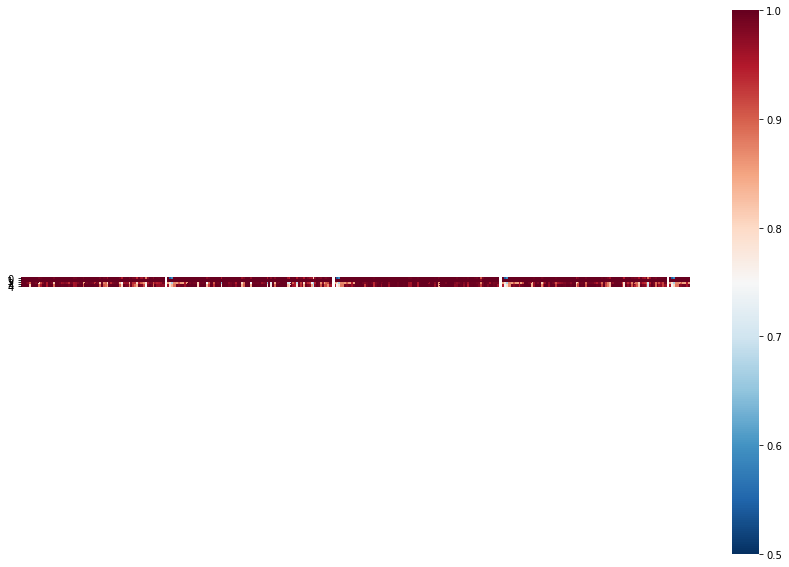

C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: All-NaN slice encountered
  


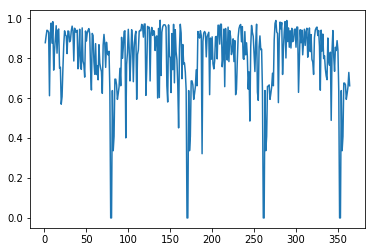

336
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]]


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


In [142]:
f, ax = plt.subplots(figsize=(15, 10))
# Draw the heatmap using seaborn
sns.heatmap(icc_vals2[:,:,9].T, square=True,cmap = 'RdBu_r', xticklabels = False, vmin = .5, vmax = 1)
plt.show()

minICC2 = np.nanmin(icc_vals2[:,:,9],axis = 1)

# Draw the heatmap using seaborn
plt.plot( range(1, icc_vals2[:,:,9].shape[0] +1),  minICC) 
plt.show()
print(np.count_nonzero(minICC2>.75))

# print(idxs)

(364, 5, 10)
['R', 'N', 'T', 'V', 'C']


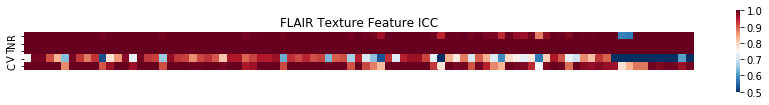

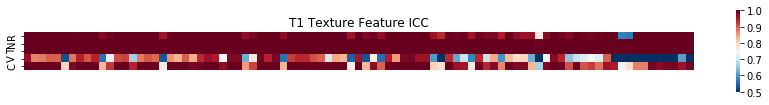

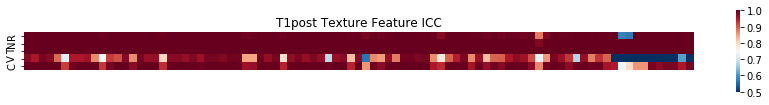

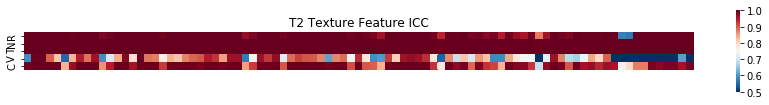

In [258]:
import pandas as pd
print(icc_vals2.shape)
print(cases)
nFeat = np.int(icc_vals2.shape[0]/len(modal_list))
# modalICC = np.zeros((len(modal_list),len(feature_names_all[0])))
modalICC = np.zeros((len(cases),len(feature_names_all[0]),len(modal_list)))
for i in range(len(modal_list)):
    modal = modal_list[i]
    idxs = np.arange(nFeat) + (i*nFeat)
    mICC = np.mean(icc_vals2[idxs,:,:],axis = 2)
#     modalICC[i,:] = np.min(mICC,axis = 1)
    modalICC[:,:,i] = mICC.T
    mICC = mICC[np.logical_not(np.isnan(mICC[:,1])),:]
    ICCDF = pd.DataFrame(data=mICC, columns=cases)
    f, ax = plt.subplots(figsize=(15, 1.5))
    # Draw the heatmap using seaborn
    sns.heatmap(ICCDF.T, square=True,cmap = 'RdBu_r', xticklabels = False, vmin = .5, vmax = 1).set_title(
        '%s Texture Feature ICC' % (modal))
    plt.show()
#     print(feature_names_all[i])
    

4
['firstorder' 'glcm' 'glrlm' 'glszm' 'ngtdm' 'shape']


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


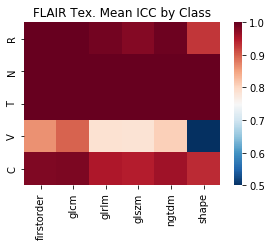

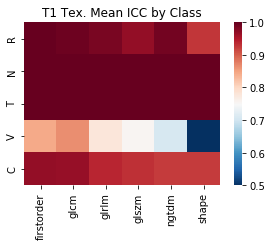

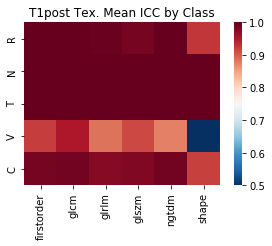

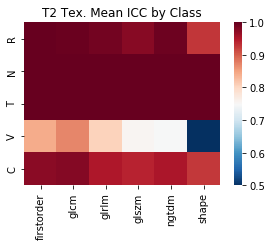

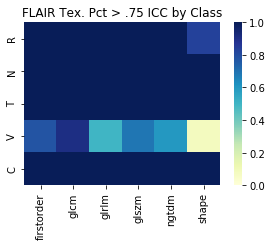

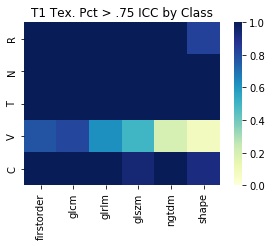

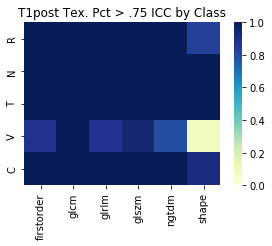

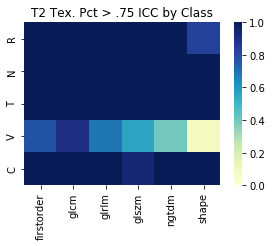

In [289]:
import re
cFeats = feature_names_all[0]
# ftPat = '^original_(\w+)_%s' % (modal_list[0])
ftPat = '^original_([^_]+)_'
# cStr = cFeats[0]
# matches = re.findall(ftPat,cStr)
# print(cStr)
# print('|'.join(modal_list))
# print(matches)
# print(matches[0])
outImDir = os.path.join(basedir,'images','ICC')
if not(os.path.exists(outImDir)):
    os.makedirs(outImDir)

print(len(feature_names_all))
# print(type(matches[0]))
ftClass = np.empty((len(feature_names_all),len(feature_names_all[0])),dtype = object)
for i in range(len(modal_list)):
    modal = modal_list[i]
    for fI in range(len(cFeats)):
        cStr = cFeats[fI]
        matches = re.findall(ftPat,cStr)
        if len(matches) > 0:
            ftClass[i,fI] = matches[0]
# print(ftClass)
print(np.unique(ftClass))
classes = np.unique(ftClass)

mICC_byClass = np.zeros((len(classes),len(cases),len(modal_list)))
pICC_byClass = np.zeros((len(classes),len(cases),len(modal_list)))
for mI in range(len(modal_list)):
    modal = modal_list[mI]
    for cI in range(len(classes)):
        cCl = classes[cI]
        idxs = np.argwhere(ftClass[mI,:]==cCl)
        cMICC = modalICC[:,:,mI]
#         print(cMICC.shape)
#         print(cMICC[idxs].T)
        mICC_byClass[cI,:,mI] = np.nanmean(cMICC[:,idxs],axis=1).T
        pICC_byClass[cI,:,mI] = (np.count_nonzero(cMICC[:,idxs] > .75,axis=1).T / 
            np.count_nonzero(np.logical_not(np.isnan(cMICC[:,idxs])),axis=1).T)
#     print(mICC_byClass[:,:,mI])
for mI in range(len(modal_list)):
    modal = modal_list[mI] 
    ICCDF = pd.DataFrame(data=mICC_byClass[:,:,mI], columns=cases,index=classes)
    f, ax = plt.subplots(figsize=(5,3))
    sns.heatmap(ICCDF.T, square=True,cmap = 'RdBu_r', vmin = .5, vmax = 1).set_title(
        '%s Tex. Mean ICC by Class' % (modal))
    plt.savefig(os.path.join(outImDir,'tex_mean_ICC_byClass_%s.png' % (modal)))
    plt.show()
for mI in range(len(modal_list)):
    modal = modal_list[mI] 
    ICCDF = pd.DataFrame(data=pICC_byClass[:,:,mI], columns=cases,index=classes)
    f, ax = plt.subplots(figsize=(5,3))
    sns.heatmap(ICCDF.T, square=True,cmap = 'YlGnBu', vmin = 0, vmax = 1).set_title(
        '%s Tex. Pct > .75 ICC by Class' % (modal))
    plt.savefig(os.path.join(outImDir,'tex_ICC_pctPass_byClass_%s.png' % (modal)))
    plt.show()

(364, 5, 10)
['R', 'N', 'T', 'V', 'C']


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


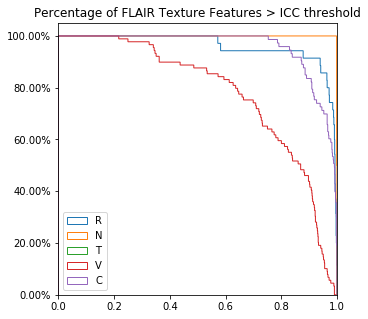

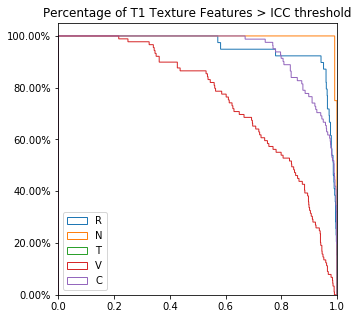

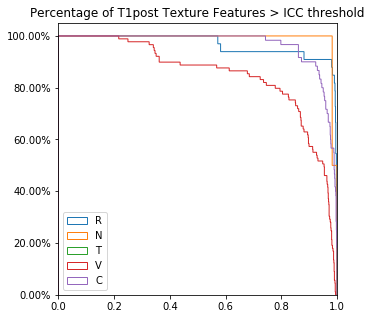

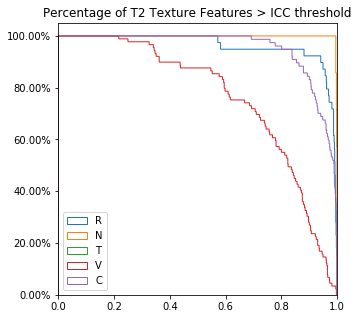

In [290]:

print(icc_vals2.shape)
print(cases)
outImDir = os.path.join(basedir,'images','ICC')
if not(os.path.exists(outImDir)):
    os.makedirs(outImDir)
nFeat = np.int(icc_vals2.shape[0]/len(modal_list))
# modalICC = np.zeros((len(modal_list),len(feature_names_all[0])))
modalICC = np.zeros((len(cases),nFeat,len(modal_list)))
for i in range(len(modal_list)):
    modal = modal_list[i]
    idxs = np.arange(nFeat) + (i*nFeat)
    mICC = np.mean(icc_vals2[idxs,:,:],axis = 2)
#     modalICC[i,:] = np.min(mICC,axis = 1)
    modalICC[:,:,i] = mICC.T
    mICC = mICC[np.logical_not(np.isnan(mICC[:,1])),:]
    ICCDF = pd.DataFrame(data=mICC, columns=cases)
#     f, ax = plt.subplots(figsize=(15, 1.5))
#     # Draw the heatmap using seaborn
#     sns.heatmap(ICCDF.T, square=True,cmap = 'RdBu_r', xticklabels = False, vmin = .5, vmax = 1).set_title(
#         '%s CNN Feature ICC' % (modal))
#     plt.show()
    f, ax = plt.subplots(figsize=(5,5))
    plt.xlim(0,1)
    plt.title('Percentage of %s Texture Features > ICC threshold' % (modal))
    # Draw the heatmap using seaborn
    for cI in range(mICC.shape[1]):
        plt.hist(mICC[:,cI],bins = np.arange(0,1,.001),histtype = 'step',density = 'true',cumulative = -1,label = cases[cI])
#         sns.distplot(mICC[:,cI], hist_kws=dict(cumulative=-1))
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    plt.legend(loc = 'lower left')
    plt.savefig(os.path.join(outImDir,'tex_ICC_Perc_Curve_%s.png' % (modal)))
    plt.show()
#     print(feature_names_all[i])
    

In [220]:
minCT = np.zeros((10,1))
for i in range(10):
    minICC2 = np.nanmin(icc_vals2[:,:,i],axis = 1)
    minCT[i] = np.count_nonzero(minICC2<=.75)
#     print(minCT[i])
print(np.mean(minCT))
print(np.count_nonzero(np.logical_not(np.isnan(minICC2))))

print(np.mean(minCT)/np.count_nonzero(np.logical_not(np.isnan(minICC2))))
print(np.count_nonzero((minICC2<=.75) & np.logical_not(np.isnan(minICC2))))

116.9
356
0.328370786516854
117


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: All-NaN slice encountered
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.


In [292]:
from rpy2.robjects import DataFrame, FloatVector, IntVector
from rpy2.robjects.packages import importr
from math import isclose

ids = np.load(os.path.join(splitdir,'label_id.npy'))
icc_vals3 = np.zeros((samples.shape[1],samples.shape[2],10))
# fold_num = 0
dataset = 'train'
for fold_num in range(10):
    icc_vals_fold = np.zeros((samples.shape[1],samples.shape[2]))
    fold_dir = os.path.join(splitdir,'fold_' +str(fold_num))
    setIdxs = np.load(os.path.join(fold_dir,dataset + '_idxs.npy')) # e.g. train, test, val

    tr_id = np.empty(len(setIdxs))

    for s_o in range(len(setIdxs)):
        s_i = setIdxs[s_o]
        tr_id[s_o]     = ids[s_i]

    tr_samples = samples[setIdxs,:,:,:]
    for prtI in range(len(cases)):
        case = cases[prtI]
        tau_vec = case_tau[case]
        if case == 'V':
            idxs = np.argwhere((np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)) > 0) & (tau_vec >=-.1) & (tau_vec <=.1))
        else:
            idxs = np.argwhere(np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)) > 0)
        groups = np.matlib.repmat(list(range(len(tr_id))), len(idxs),1).T.ravel()
        for ftN in range(samples.shape[1]):
            if (ftN % 100) == 0: 
                print('%d %d %d - ' % (fold_num, prtI,ftN), datetime.datetime.now().time())
            values = tr_samples[:,ftN,prtI,idxs].ravel()
            r_icc = importr("ICC")
            df = DataFrame({"groups": IntVector(groups),
                            "values": FloatVector(values)})
            icc_res = r_icc.ICCbare("groups", "values", data=df)
            icc_vals_fold[ftN,prtI] = icc_res[0] # icc_vals now holds the icc value
    icc_vals3[:,:,fold_num] = icc_vals_fold
    minICC3 = np.nanmin(icc_vals_fold,axis = 1)
    minICC3[np.isnan(minICC3)] = 0
    np.save(os.path.join(fold_dir,'tex_feature_min_icc3.npy'),minICC3)
# check whether icc value equals reference value
# print(isclose(icc_val, 0.728, abs_tol=0.001))

0 0 0 -  17:34:10.493926
0 0 100 -  17:34:11.704022
0 0 200 -  17:34:12.802971
0 0 300 -  17:34:13.895871
0 1 0 -  17:34:14.643833
0 1 100 -  17:34:15.861370
0 1 200 -  17:34:17.113685
0 1 300 -  17:34:18.372022
0 2 0 -  17:34:19.127025
0 2 100 -  17:34:19.878021
0 2 200 -  17:34:20.618983
0 2 300 -  17:34:21.402033
0 3 0 -  17:34:21.891836
0 3 100 -  17:34:22.641997
0 3 200 -  17:34:23.413045
0 3 300 -  17:34:24.197730
0 4 0 -  17:34:24.726132
0 4 100 -  17:34:25.847164
0 4 200 -  17:34:26.995213
0 4 300 -  17:34:28.161303


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: All-NaN slice encountered


1 0 0 -  17:34:29.306823
1 0 100 -  17:34:30.487956
1 0 200 -  17:34:31.627628
1 0 300 -  17:34:32.803749
1 1 0 -  17:34:33.677063
1 1 100 -  17:34:35.051680
1 1 200 -  17:34:36.326711
1 1 300 -  17:34:37.629165
1 2 0 -  17:34:38.562643
1 2 100 -  17:34:39.468045
1 2 200 -  17:34:40.327038
1 2 300 -  17:34:41.185350
1 3 0 -  17:34:41.782923
1 3 100 -  17:34:42.708390
1 3 200 -  17:34:43.596714
1 3 300 -  17:34:44.513144
1 4 0 -  17:34:45.096693
1 4 100 -  17:34:46.420203
1 4 200 -  17:34:47.747726
1 4 300 -  17:34:49.034167
2 0 0 -  17:34:50.139573
2 0 100 -  17:34:51.492196
2 0 200 -  17:34:52.912932
2 0 300 -  17:34:54.240614
2 1 0 -  17:34:55.126936
2 1 100 -  17:34:56.692619
2 1 200 -  17:34:58.234710
2 1 300 -  17:34:59.702607
2 2 0 -  17:35:00.720304
2 2 100 -  17:35:01.671828
2 2 200 -  17:35:02.627363
2 2 300 -  17:35:03.531763
2 3 0 -  17:35:04.140377
2 3 100 -  17:35:05.054621
2 3 200 -  17:35:05.964000
2 3 300 -  17:35:06.869435
2 4 0 -  17:35:07.500108
2 4 100 -  17:35:08.9

(364, 5, 10)
['R', 'N', 'T', 'V', 'C']


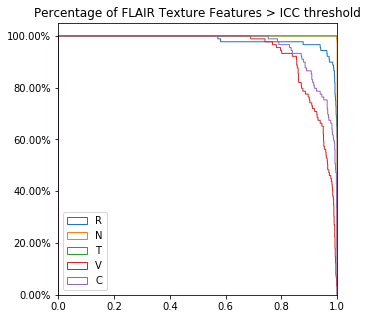

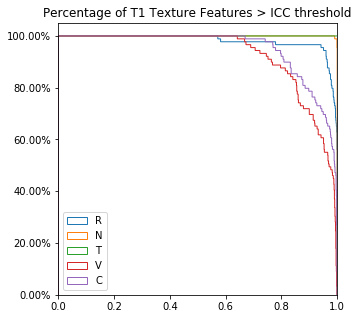

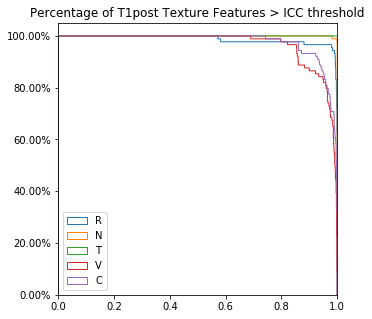

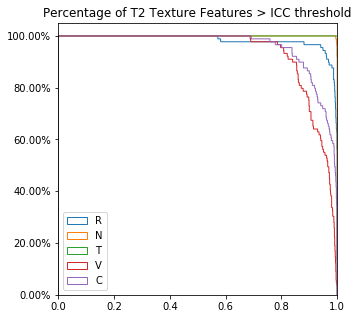

In [301]:
print(icc_vals3.shape)
print(cases)
outImDir = os.path.join(basedir,'images','ICC')
if not(os.path.exists(outImDir)):
    os.makedirs(outImDir)
nFeat = np.int(icc_vals3.shape[0]/len(modal_list))
# modalICC = np.zeros((len(modal_list),len(feature_names_all[0])))
modalICC = np.zeros((len(cases),nFeat,len(modal_list)))
for i in range(len(modal_list)):
    modal = modal_list[i]
    idxs = np.arange(nFeat) + (i*nFeat)
    mICC = np.mean(icc_vals3[idxs,:,:],axis = 2)
#     modalICC[i,:] = np.min(mICC,axis = 1)
    modalICC[:,:,i] = mICC.T
    mICC = mICC[np.logical_not(np.isnan(mICC[:,1])),:]
    ICCDF = pd.DataFrame(data=mICC, columns=cases)
#     f, ax = plt.subplots(figsize=(15, 1.5))
#     # Draw the heatmap using seaborn
#     sns.heatmap(ICCDF.T, square=True,cmap = 'RdBu_r', xticklabels = False, vmin = .5, vmax = 1).set_title(
#         '%s CNN Feature ICC' % (modal))
#     plt.show()
    f, ax = plt.subplots(figsize=(5,5))
    plt.xlim(0,1)
    plt.title('Percentage of %s Texture Features > ICC threshold' % (modal))
    # Draw the heatmap using seaborn
    for cI in range(mICC.shape[1]):
        plt.hist(mICC[:,cI],bins = np.arange(0,1.01,.001),histtype = 'step',density = 'true',cumulative = -1,label = cases[cI])
#         sns.distplot(mICC[:,cI], hist_kws=dict(cumulative=-1))
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    plt.legend(loc = 'lower left')
    plt.savefig(os.path.join(outImDir,'tex_ICC_Perc_Curve_%s_icc3.png' % (modal)))
    plt.show()
#     print(feature_names_all[i])
    

4
['firstorder' 'glcm' 'glrlm' 'glszm' 'ngtdm' 'shape']


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


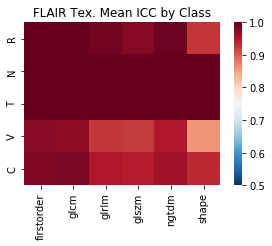

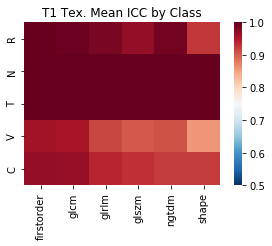

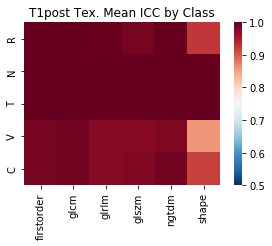

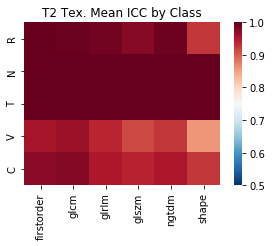

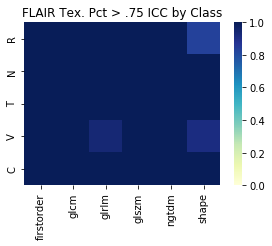

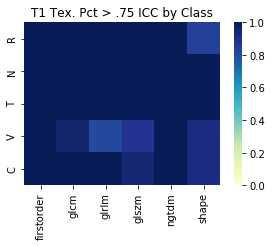

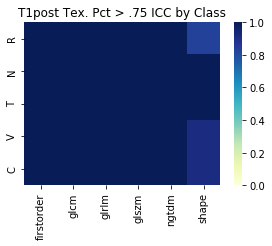

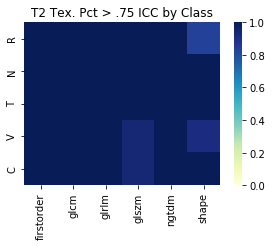

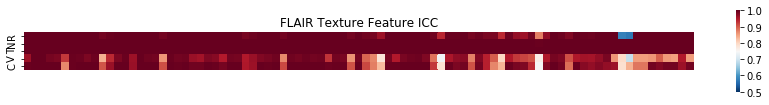

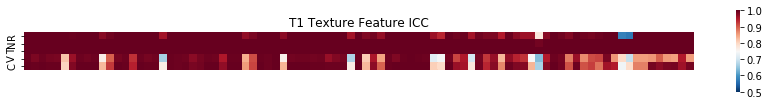

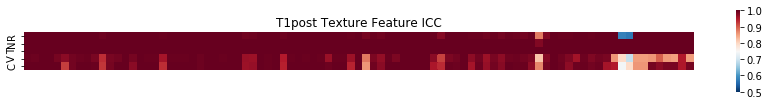

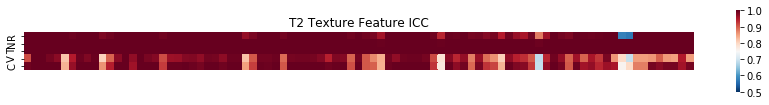

In [294]:
import re
cFeats = feature_names_all[0]
# ftPat = '^original_(\w+)_%s' % (modal_list[0])
ftPat = '^original_([^_]+)_'
# cStr = cFeats[0]
# matches = re.findall(ftPat,cStr)
# print(cStr)
# print('|'.join(modal_list))
# print(matches)
# print(matches[0])
outImDir = os.path.join(basedir,'images','ICC')
if not(os.path.exists(outImDir)):
    os.makedirs(outImDir)

print(len(feature_names_all))
# print(type(matches[0]))
ftClass = np.empty((len(feature_names_all),len(feature_names_all[0])),dtype = object)
for i in range(len(modal_list)):
    modal = modal_list[i]
    for fI in range(len(cFeats)):
        cStr = cFeats[fI]
        matches = re.findall(ftPat,cStr)
        if len(matches) > 0:
            ftClass[i,fI] = matches[0]
# print(ftClass)
print(np.unique(ftClass))
classes = np.unique(ftClass)

mICC_byClass = np.zeros((len(classes),len(cases),len(modal_list)))
pICC_byClass = np.zeros((len(classes),len(cases),len(modal_list)))
for mI in range(len(modal_list)):
    modal = modal_list[mI]
    for cI in range(len(classes)):
        cCl = classes[cI]
        idxs = np.argwhere(ftClass[mI,:]==cCl)
        cMICC = modalICC[:,:,mI]
#         print(cMICC.shape)
#         print(cMICC[idxs].T)
        mICC_byClass[cI,:,mI] = np.nanmean(cMICC[:,idxs],axis=1).T
        pICC_byClass[cI,:,mI] = (np.count_nonzero(cMICC[:,idxs] > .75,axis=1).T / 
            np.count_nonzero(np.logical_not(np.isnan(cMICC[:,idxs])),axis=1).T)
#     print(mICC_byClass[:,:,mI])
for mI in range(len(modal_list)):
    modal = modal_list[mI] 
    ICCDF = pd.DataFrame(data=mICC_byClass[:,:,mI], columns=cases,index=classes)
    f, ax = plt.subplots(figsize=(5,3))
    sns.heatmap(ICCDF.T, square=True,cmap = 'RdBu_r', vmin = .5, vmax = 1).set_title(
        '%s Tex. Mean ICC by Class' % (modal))
    plt.savefig(os.path.join(outImDir,'tex_mean_ICC_byClass_%s_icc3.png' % (modal)))
    plt.show()
for mI in range(len(modal_list)):
    modal = modal_list[mI] 
    ICCDF = pd.DataFrame(data=pICC_byClass[:,:,mI], columns=cases,index=classes)
    f, ax = plt.subplots(figsize=(5,3))
    sns.heatmap(ICCDF.T, square=True,cmap = 'YlGnBu', vmin = 0, vmax = 1).set_title(
        '%s Tex. Pct > .75 ICC by Class' % (modal))
    plt.savefig(os.path.join(outImDir,'tex_ICC_pctPass_byClass_%s_icc3.png' % (modal)))
    plt.show()

nFeat = np.int(icc_vals3.shape[0]/len(modal_list))
for i in range(len(modal_list)):
    modal = modal_list[i]
    idxs = np.arange(nFeat) + (i*nFeat)
    mICC = np.mean(icc_vals3[idxs,:,:],axis = 2)
    mICC = mICC[np.logical_not(np.isnan(mICC[:,1])),:]
    ICCDF = pd.DataFrame(data=mICC, columns=cases)
    f, ax = plt.subplots(figsize=(15, 1.5))
    # Draw the heatmap using seaborn
    sns.heatmap(ICCDF.T, square=True,cmap = 'RdBu_r', xticklabels = False, vmin = .5, vmax = 1).set_title(
        '%s Texture Feature ICC' % (modal))
    plt.savefig(os.path.join(outImDir,'tex_ICC_heatmap_%s_icc3.png' % (modal)))
    plt.show()

In [300]:
minCT = np.zeros((10,1))
minCT4 = np.zeros((10,1))
for i in range(10):
    minICC3 = np.nanmin(icc_vals3[:,:,i],axis = 1)
    minCT[i] = np.count_nonzero(minICC3<=.75)
    minCT4[i] = np.count_nonzero(minICC3<=.9)
#     print(minCT[i])
print(np.mean(minCT))
print(np.count_nonzero(np.logical_not(np.isnan(minICC3))))

print('0.75 ICC thresh: %f' % (np.mean(minCT)/np.count_nonzero(np.logical_not(np.isnan(minICC3)))))
# print(np.count_nonzero((minICC3<=.75) & np.logical_not(np.isnan(minICC3))))

print(np.mean(minCT4))
print('0.9 ICC thresh: %f' % (np.mean(minCT4)/np.count_nonzero(np.logical_not(np.isnan(minICC3)))))

17.9
356
0.75 ICC thresh: 0.050281
86.2
0.9 ICC thresh: 0.242135


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """
C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


In [ ]:
mask = np.load(os.path.join(splitdir,'slices_exp_mask.npy'))
img = {}
inten_dic = {}
for modal in modal_list:
    #load image and mask
    img[modal] = np.load(os.path.join(splitdir,'slices_exp_%s.npy' % (modal)))


# tau_vec = np.arange(-.28,.28+.2,.02)
features = {}
# case = 'C'
case_tau = {'R' : np.arange(-13,13+1,1),'N':np.arange(1,30+1,1),'T':[p for p in itertools.product([0,1/3,2/3], repeat=2)],
           'V': np.arange(-.28,.28+.2,.02),'C': np.arange(1,30+1,1),'RT':[p for p in itertools.product([-6,-2,2,6],[.25,.75]),
            'RNT': p for p in itertools.product([-6,-2,2,6],[0],[.25,.75])}
cases = ['RT']

for modal in modal_list:
    features[modal] = {}

    # [n_slices, x_dim, y_dim, views]
    n_slices = img[modal].shape[0]
    
#     slice_ind = 25
#     if 1:
    for slice_ind in range(n_slices):

        features[modal][slice_ind] = {}

        # for view_ind in range(len(views)):
            # pick slice and view
        img_slice = img[modal][slice_ind,:,:,2]
        mask_slice = (mask[slice_ind,:,:,2] > 0) * 1
        for case in cases:
            print('%s %s - %d' % (modal,case,slice_ind), datetime.datetime.now().time())
            features[modal][slice_ind][case] = {}
            tau_vec = case_tau[case]
            
            for adi in range(len(tau_vec)):
    #             print('%s - %d - %f' % (modal,slice_ind,tau))
                features[modal][slice_ind][case][adi] = {}
                tau = tau_vec[adi]
                if case == 'R':
                    adj_mask = impt.rotate_image(mask_slice,tau,mask_slice)
                    adj_slice = impt.rotate_image(img_slice,tau,mask_slice)
                elif case == 'N':
                    np.random.seed(tau)
                    adj_slice = impt.add_noise(img_slice,reps=1)
                    adj_mask = mask_slice.copy()
                elif case == 'T':
                    adj_slice = impt.translate_image(img_slice,shift=tau)
                    adj_mask = impt.translate_image(mask_slice,shift=tau)
                elif case == 'V':
                    adj_slice = img_slice.copy()
                    adj_mask = impt.grow_shrink_image(mask_slice,tau)
                elif case == 'C':
                    np.random.seed(tau)
                    adj_slice = img_slice.copy()
                    adj_mask = impt.adjust_image_contour(img_slice,mask_slice)

                #convert numpy array into sitk

                sitk_img = sitk.GetImageFromArray(adj_slice)
                sitk_img.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
                sitk_img = sitk.JoinSeries(sitk_img)

                sitk_mask = sitk.GetImageFromArray(adj_mask)
                sitk_mask.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
                sitk_mask = sitk.JoinSeries(sitk_mask)
                sitk_mask = sitk.Cast(sitk_mask, sitk.sitkInt32)

                features[modal][slice_ind][case][adi]['z']=extractor.execute(sitk_img, sitk_mask)